# Hypothesentests
* H01: Die Mitglieder der AfD twittern höchstens 20\% mehr OFFENSE-Tweets als die Mitglieder jeder anderen Partei.
* H02: Die Häufigkeit von OFFENSE-Tweets vor dem Corona Lockdown unterscheidet sich NICHT von der während dem Lockdown.
* H03: Die Häufigkeit von OFFENSE-Tweets vor dem Corona Lockdown unterscheidet sich NICHT von der nach dem Lockdown.
* H04: Die Mitglieder der AfD rufen im Parlament höchstens genauso oft OFFENSE-Zurufe hinein wie die Mitglieder jeder anderen Partei.
* H05: Die Mitglieder jeder Partei rufen im Plenum höchstens genauso oft OFFENSE-Zurufe hinein wie sie OFFENSE-Tweets absetzen.


In [2]:
import pandas as pd
import datetime
import pickle, gensim, numpy as np

sent_df_Wien = pickle.load(open('/home/lisa/Darmstadt/Master Arbeit/06_Analyse/sent_df_Wien_final.p', "rb" ))
# Tweets von Johannes Kahrs werdne entfernt um Normalverteilung zu erhalten
sent_df_Wien = sent_df_Wien.loc[sent_df_Wien['user_screen_name'] != 'kahrs'] 

In [3]:
import pandas as pd
time = ['month', 'week', 'date']
cat = ['', 'OFFENSE', 'OTHER']
twitter_dic = {}

#time = ['week', 'date']
#cat = ['OTHER']


for c in cat: 
    if c == '':
        sent_df = sent_df_Wien
    else:
        sent_df = sent_df_Wien.loc[sent_df_Wien['predict'] == c]
    for t in time:
        twitter_dic['piv_'+t+c] = pd.pivot_table(sent_df, index = [t], columns = ['user_party'], aggfunc = np.count_nonzero)['full_text'].fillna(0)  

twitter_dic.keys()

dict_keys(['piv_month', 'piv_week', 'piv_date', 'piv_monthOFFENSE', 'piv_weekOFFENSE', 'piv_dateOFFENSE', 'piv_monthOTHER', 'piv_weekOTHER', 'piv_dateOTHER'])

# Check for Normality

In [19]:
# https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/
# generate gaussian data
from numpy.random import seed
from numpy.random import randn
from numpy import mean
from numpy import std
# seed the random number generator
seed(1)
# generate univariate observations
data = 5 * randn(100) + 50

# summarize
print('mean=%.3f stdv=%.3f' % (mean(data), std(data)))
print('mean=%.3f stdv=%.3f' % (mean(twitter_dic['piv_week']['Union']), std(twitter_dic['piv_week']['Union'])))

mean=50.303 stdv=4.426
mean=582.910 stdv=130.354


In [20]:
durch = []
partei = []
daten = []

for dat in twitter_dic.keys():
    for party in twitter_dic['piv_month'].columns:
        daten.append(dat)
        partei.append(party)
        durch.append('Mean: '+ str(mean(twitter_dic[dat][party]).round(3)) + ' Std:'+str(std(twitter_dic[dat][party]).round(3)))

data_mean_std = pd.DataFrame({'Datensatz': daten, 'Partei': partei, 'Mean': durch})
data_mean_std_piv = pd.pivot_table(data_mean_std, values = 'Mean', index = 'Datensatz', columns = 'Partei', aggfunc = min)

### Scatterplots

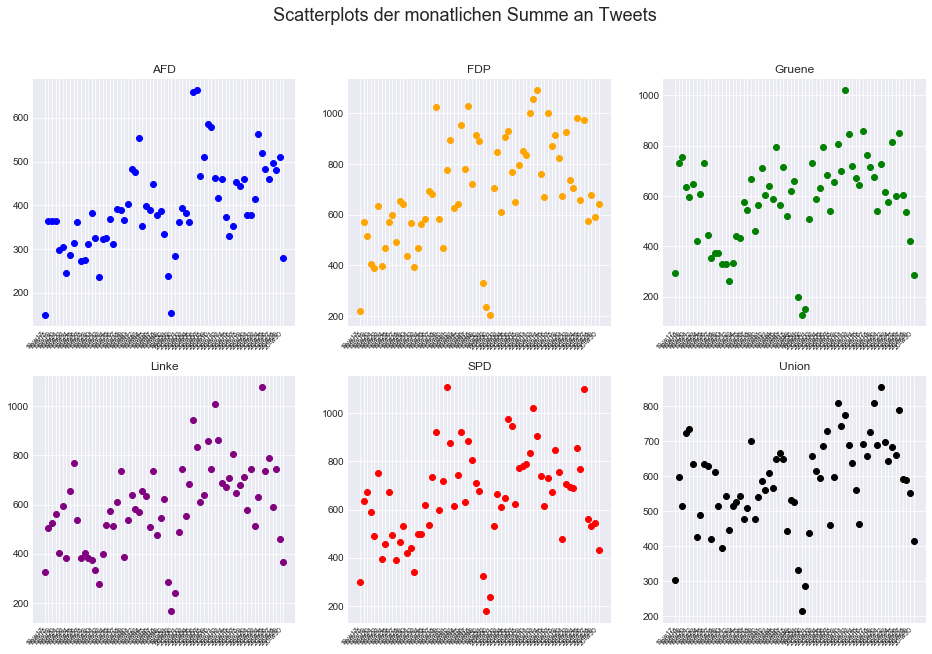

In [21]:
from matplotlib import pyplot
datensatz = twitter_dic['piv_week']
pyplot.style.use('seaborn-darkgrid')
my_palette = ['blue', 'orange', 'green', 'purple', 'red', 'black']

fig = pyplot.figure(figsize = (16,10))
fig.suptitle('Scatterplots der monatlichen Summe an Tweets', fontsize = 18)

num = 0
for party, n in zip(datensatz.columns, range(1,7)):
    ax = fig.add_subplot(2,3,n)
    ax.scatter(datensatz.index, datensatz[party], color = my_palette[num])
    x_tags = pyplot.xticks(datensatz.index, fontsize = 7, rotation = 45, ha = "right")
    ax.set_title(party)
    num = num + 1

### Histograme

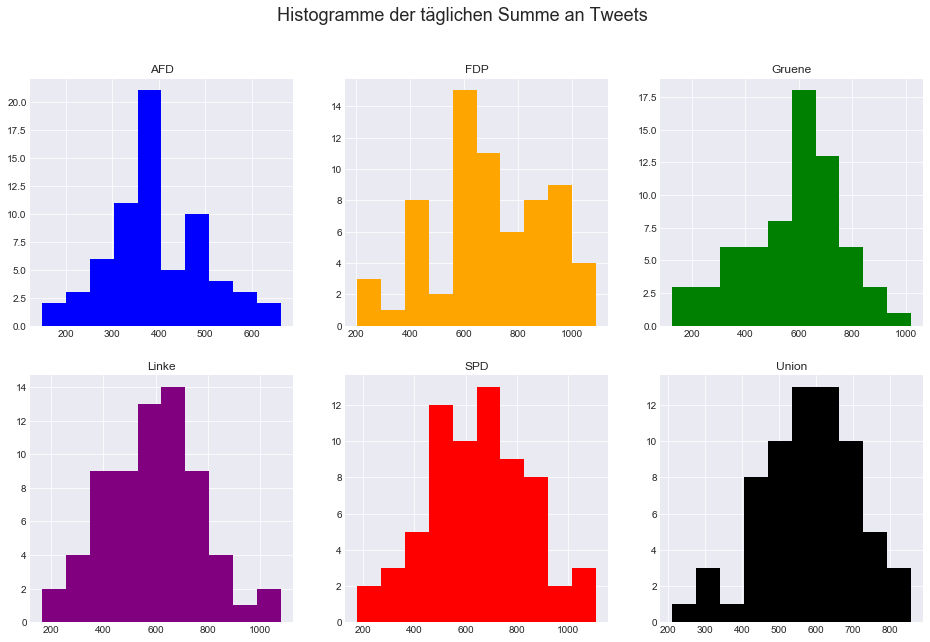

In [22]:
datensatz = twitter_dic['piv_week']
pyplot.style.use('seaborn-darkgrid')
my_palette = ['blue', 'orange', 'green', 'purple', 'red', 'black']
Parteien = ['AFD', 'FDP', 'Gruene', 'Linke', 'SPD', 'Union']

fig = pyplot.figure(figsize = (16,10))
fig.suptitle('Histogramme der täglichen Summe an Tweets', fontsize = 18)

num = 0
for party, n in zip(datensatz.columns, range(1,7)):
    ax = fig.add_subplot(2,3,n)
    ax.hist(datensatz[party], color = my_palette[num])
    ax.set_title(party)
    num = num + 1


### QQ Plot

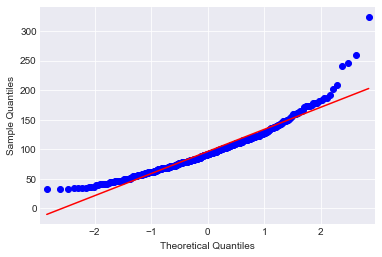

In [23]:
# QQ Plot
from statsmodels.graphics.gofplots import qqplot

qqplot(twitter_dic['piv_date']['SPD'], line='s')
pyplot.show()

## Tests auf Normalverteilung

### Shapiro-Wilk

In [24]:
# Shapiro-Wilk Test
from scipy.stats import shapiro

partei = []
dataset = []
result = []

for party in twitter_dic['piv_month'].columns:
    for dat in twitter_dic.keys():
        partei.append(party)
        dataset.append(dat)
# normality test
        stat, p = shapiro(twitter_dic[dat][party])

# interpret
        alpha = 0.05
        if p > alpha:
            result.append('Stats=%.3f, p=%.3f' % (stat, p) + ' Gaussian')
        else:
            result.append('Stats=%.3f, p=%.3f' % (stat, p) + ' NOT Gaussian')
            
Shapiro_Wilk_df = pd.DataFrame({'Partei':partei, 'Daten':dataset, 'Ergebnis':result})
Shapiro_Wilk_piv = pd.pivot_table(Shapiro_Wilk_df, values='Ergebnis', index=['Daten'], columns=['Partei'], aggfunc=max)
Shapiro_Wilk_piv

Partei,AFD,FDP,Gruene,Linke,SPD,Union
Daten,,,,,,
piv_date,"Stats=0.950, p=0.000 NOT Gaussian","Stats=0.969, p=0.000 NOT Gaussian","Stats=0.978, p=0.000 NOT Gaussian","Stats=0.960, p=0.000 NOT Gaussian","Stats=0.931, p=0.000 NOT Gaussian","Stats=0.972, p=0.000 NOT Gaussian"
piv_dateOFFENSE,"Stats=0.854, p=0.000 NOT Gaussian","Stats=0.847, p=0.000 NOT Gaussian","Stats=0.566, p=0.000 NOT Gaussian","Stats=0.698, p=0.000 NOT Gaussian","Stats=0.386, p=0.000 NOT Gaussian","Stats=0.883, p=0.000 NOT Gaussian"
piv_dateOTHER,"Stats=0.986, p=0.000 NOT Gaussian","Stats=0.967, p=0.000 NOT Gaussian","Stats=0.980, p=0.000 NOT Gaussian","Stats=0.971, p=0.000 NOT Gaussian","Stats=0.951, p=0.000 NOT Gaussian","Stats=0.973, p=0.000 NOT Gaussian"
piv_month,"Stats=0.949, p=0.508 Gaussian","Stats=0.938, p=0.361 Gaussian","Stats=0.961, p=0.711 Gaussian","Stats=0.983, p=0.987 Gaussian","Stats=0.974, p=0.912 Gaussian","Stats=0.935, p=0.321 Gaussian"
piv_monthOFFENSE,"Stats=0.941, p=0.389 Gaussian","Stats=0.925, p=0.227 Gaussian","Stats=0.741, p=0.001 NOT Gaussian","Stats=0.814, p=0.006 NOT Gaussian","Stats=0.612, p=0.000 NOT Gaussian","Stats=0.981, p=0.975 Gaussian"
piv_monthOTHER,"Stats=0.926, p=0.240 Gaussian","Stats=0.941, p=0.395 Gaussian","Stats=0.972, p=0.887 Gaussian","Stats=0.980, p=0.970 Gaussian","Stats=0.974, p=0.916 Gaussian","Stats=0.932, p=0.290 Gaussian"
piv_week,"Stats=0.979, p=0.330 Gaussian","Stats=0.979, p=0.327 Gaussian","Stats=0.973, p=0.144 Gaussian","Stats=0.991, p=0.917 Gaussian","Stats=0.995, p=0.995 Gaussian","Stats=0.985, p=0.622 Gaussian"
piv_weekOFFENSE,"Stats=0.877, p=0.000 NOT Gaussian","Stats=0.896, p=0.000 NOT Gaussian","Stats=0.722, p=0.000 NOT Gaussian","Stats=0.799, p=0.000 NOT Gaussian","Stats=0.546, p=0.000 NOT Gaussian","Stats=0.932, p=0.001 NOT Gaussian"
piv_weekOTHER,"Stats=0.987, p=0.718 Gaussian","Stats=0.982, p=0.424 Gaussian","Stats=0.978, p=0.283 Gaussian","Stats=0.984, p=0.565 Gaussian","Stats=0.993, p=0.970 Gaussian","Stats=0.979, p=0.319 Gaussian"


### D'Agostino und Pearson Test

In [25]:
# D'Agostino and Pearson's Test
from scipy.stats import normaltest

partei = []
dataset = []
result = []
    
for party in twitter_dic['piv_month'].columns:
    for dat in twitter_dic.keys():
        partei.append(party)
        dataset.append(dat)
# normality test
        stat, p = normaltest(twitter_dic[dat][party])
# interpret
        alpha = 0.05
        if p > alpha:
            result.append('Stats=%.3f, p=%.3f' % (stat, p) + ' Gaussian')
        else:
            result.append('Stats=%.3f, p=%.3f' % (stat, p) + ' NOT Gaussian')
            
Agostino_Pearson_df = pd.DataFrame({'Partei':partei, 'Daten':dataset, 'Ergebnis':result})
Agostino_Pearson_piv =  pd.pivot_table(Agostino_Pearson_df, values='Ergebnis', index=['Daten'], columns=['Partei'], aggfunc=max)
Agostino_Pearson_piv

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))


Partei,AFD,FDP,Gruene,Linke,SPD,Union
Daten,,,,,,
piv_date,"Stats=107.643, p=0.000 NOT Gaussian","Stats=23.123, p=0.000 NOT Gaussian","Stats=27.207, p=0.000 NOT Gaussian","Stats=68.328, p=0.000 NOT Gaussian","Stats=129.015, p=0.000 NOT Gaussian","Stats=32.899, p=0.000 NOT Gaussian"
piv_dateOFFENSE,"Stats=246.352, p=0.000 NOT Gaussian","Stats=187.497, p=0.000 NOT Gaussian","Stats=656.539, p=0.000 NOT Gaussian","Stats=480.492, p=0.000 NOT Gaussian","Stats=839.665, p=0.000 NOT Gaussian","Stats=171.867, p=0.000 NOT Gaussian"
piv_dateOTHER,"Stats=21.627, p=0.000 NOT Gaussian","Stats=23.928, p=0.000 NOT Gaussian","Stats=16.605, p=0.000 NOT Gaussian","Stats=34.553, p=0.000 NOT Gaussian","Stats=76.895, p=0.000 NOT Gaussian","Stats=31.996, p=0.000 NOT Gaussian"
piv_month,"Stats=1.635, p=0.442 Gaussian","Stats=0.294, p=0.863 Gaussian","Stats=0.949, p=0.622 Gaussian","Stats=0.470, p=0.791 Gaussian","Stats=0.315, p=0.854 Gaussian","Stats=2.510, p=0.285 Gaussian"
piv_monthOFFENSE,"Stats=3.335, p=0.189 Gaussian","Stats=5.541, p=0.063 Gaussian","Stats=23.470, p=0.000 NOT Gaussian","Stats=16.856, p=0.000 NOT Gaussian","Stats=32.099, p=0.000 NOT Gaussian","Stats=0.356, p=0.837 Gaussian"
piv_monthOTHER,"Stats=2.990, p=0.224 Gaussian","Stats=0.234, p=0.890 Gaussian","Stats=0.588, p=0.745 Gaussian","Stats=0.890, p=0.641 Gaussian","Stats=0.129, p=0.937 Gaussian","Stats=2.432, p=0.296 Gaussian"
piv_week,"Stats=2.098, p=0.350 Gaussian","Stats=1.211, p=0.546 Gaussian","Stats=2.572, p=0.276 Gaussian","Stats=0.458, p=0.795 Gaussian","Stats=0.007, p=0.996 Gaussian","Stats=2.462, p=0.292 Gaussian"
piv_weekOFFENSE,"Stats=30.631, p=0.000 NOT Gaussian","Stats=28.431, p=0.000 NOT Gaussian","Stats=78.257, p=0.000 NOT Gaussian","Stats=53.861, p=0.000 NOT Gaussian","Stats=107.846, p=0.000 NOT Gaussian","Stats=17.365, p=0.000 NOT Gaussian"
piv_weekOTHER,"Stats=0.125, p=0.940 Gaussian","Stats=0.776, p=0.678 Gaussian","Stats=1.979, p=0.372 Gaussian","Stats=0.909, p=0.635 Gaussian","Stats=0.072, p=0.965 Gaussian","Stats=4.116, p=0.128 Gaussian"


### Anderson-Darling Test

In [27]:
# Anderson-Darling Test
from scipy.stats import anderson

partei = []
dataset = []
result = []

for party in twitter_dic['piv_month'].columns:
    for dat in twitter_dic.keys():
        partei.append(party)
        dataset.append(dat)
# normality test
        resultat = anderson(twitter_dic[dat][party])
        p = 0
        for i in range(len(resultat.critical_values)):
            sl, cv = resultat.significance_level[i], resultat.critical_values[i]
            
        if resultat.statistic < resultat.critical_values[i]:
            result.append('%.3f: %.3f, data looks normal' % (sl, cv))
        else:
            result.append('%.3f: %.3f, NOT (reject H0)' % (sl, cv))
            
            
            
Anderson_Darling_df = pd.DataFrame({'Partei':partei, 'Daten':dataset, 'Ergebnis':result})
Anderson_Darling_piv = pd.pivot_table(Anderson_Darling_df, values='Ergebnis', index=['Daten'], columns=['Partei'], aggfunc=max)
Anderson_Darling_piv

Partei,AFD,FDP,Gruene,Linke,SPD,Union
Daten,,,,,,
piv_date,"1.000: 1.083, NOT (reject H0)","1.000: 1.083, NOT (reject H0)","1.000: 1.083, NOT (reject H0)","1.000: 1.083, NOT (reject H0)","1.000: 1.083, NOT (reject H0)","1.000: 1.083, NOT (reject H0)"
piv_dateOFFENSE,"1.000: 1.083, NOT (reject H0)","1.000: 1.083, NOT (reject H0)","1.000: 1.083, NOT (reject H0)","1.000: 1.083, NOT (reject H0)","1.000: 1.083, NOT (reject H0)","1.000: 1.083, NOT (reject H0)"
piv_dateOTHER,"1.000: 1.083, data looks normal","1.000: 1.083, NOT (reject H0)","1.000: 1.083, NOT (reject H0)","1.000: 1.083, NOT (reject H0)","1.000: 1.083, NOT (reject H0)","1.000: 1.083, NOT (reject H0)"
piv_month,"1.000: 0.945, data looks normal","1.000: 0.945, data looks normal","1.000: 0.945, data looks normal","1.000: 0.945, data looks normal","1.000: 0.945, data looks normal","1.000: 0.945, data looks normal"
piv_monthOFFENSE,"1.000: 0.945, data looks normal","1.000: 0.945, data looks normal","1.000: 0.945, NOT (reject H0)","1.000: 0.945, data looks normal","1.000: 0.945, NOT (reject H0)","1.000: 0.945, data looks normal"
piv_monthOTHER,"1.000: 0.945, data looks normal","1.000: 0.945, data looks normal","1.000: 0.945, data looks normal","1.000: 0.945, data looks normal","1.000: 0.945, data looks normal","1.000: 0.945, data looks normal"
piv_week,"1.000: 1.036, data looks normal","1.000: 1.036, data looks normal","1.000: 1.036, data looks normal","1.000: 1.036, data looks normal","1.000: 1.036, data looks normal","1.000: 1.036, data looks normal"
piv_weekOFFENSE,"1.000: 1.036, NOT (reject H0)","1.000: 1.036, NOT (reject H0)","1.000: 1.036, NOT (reject H0)","1.000: 1.036, NOT (reject H0)","1.000: 1.036, NOT (reject H0)","1.000: 1.036, data looks normal"
piv_weekOTHER,"1.000: 1.036, data looks normal","1.000: 1.036, data looks normal","1.000: 1.036, data looks normal","1.000: 1.036, data looks normal","1.000: 1.036, data looks normal","1.000: 1.036, data looks normal"


# Corellationstests

In [28]:
data_mean_std_piv

Partei,AFD,FDP,Gruene,Linke,SPD,Union
Datensatz,,,,,,
piv_date,Mean: 57.896 Std:19.989,Mean: 101.872 Std:44.148,Mean: 85.753 Std:34.219,Mean: 86.916 Std:35.129,Mean: 96.247 Std:37.369,Mean: 86.024 Std:27.308
piv_dateOFFENSE,Mean: 19.463 Std:9.834,Mean: 5.841 Std:4.279,Mean: 5.689 Std:5.885,Mean: 10.449 Std:8.159,Mean: 5.465 Std:7.914,Mean: 5.7 Std:4.045
piv_dateOTHER,Mean: 38.434 Std:13.087,Mean: 96.031 Std:42.428,Mean: 80.064 Std:31.806,Mean: 76.467 Std:30.864,Mean: 90.782 Std:34.269,Mean: 80.324 Std:25.758
piv_month,Mean: 1752.333 Std:337.945,Mean: 3083.333 Std:596.482,Mean: 2595.467 Std:530.8,Mean: 2630.667 Std:518.135,Mean: 2913.067 Std:515.877,Mean: 2603.667 Std:350.754
piv_monthOFFENSE,Mean: 589.067 Std:150.705,Mean: 176.8 Std:46.654,Mean: 172.2 Std:74.994,Mean: 316.267 Std:103.085,Mean: 165.4 Std:95.605,Mean: 172.533 Std:42.44
piv_monthOTHER,Mean: 1163.267 Std:216.111,Mean: 2906.533 Std:569.163,Mean: 2423.267 Std:508.037,Mean: 2314.4 Std:474.661,Mean: 2747.667 Std:479.05,Mean: 2431.133 Std:327.087
piv_week,Mean: 392.313 Std:103.032,Mean: 690.299 Std:211.675,Mean: 581.075 Std:181.077,Mean: 588.955 Std:180.945,Mean: 652.179 Std:197.212,Mean: 582.91 Std:130.354
piv_weekOFFENSE,Mean: 131.881 Std:47.214,Mean: 39.582 Std:16.75,Mean: 38.552 Std:24.095,Mean: 70.806 Std:35.229,Mean: 37.03 Std:30.507,Mean: 38.627 Std:15.232
piv_weekOTHER,Mean: 260.433 Std:67.859,Mean: 650.716 Std:203.263,Mean: 542.522 Std:170.911,Mean: 518.149 Std:161.509,Mean: 615.149 Std:184.621,Mean: 544.284 Std:123.681


### Pearson's Correlation test


*    Observations in each sample are independent and identically distributed (iid).
*    Observations in each sample are normally distributed.
*    Observations in each sample have the same variance.


*    H0: the two samples are independent.
*    H1: there is a dependency between the samples.

Ergibt Sinn, dass fasst alle dependent sind!
-> Getrieben von äußeren Events auf die fast alle Politiker*innen reagieren

In [29]:
from scipy.stats import pearsonr

partei = []
dataset = []
result = []

for party in twitter_dic['piv_month'].columns:
    for dat in twitter_dic.keys():
        partei.append(party)
        dataset.append(dat)
# normality test
        stat, p = pearsonr(twitter_dic[dat][party], twitter_dic[dat]['AFD'])

        if p > 0.05:
            result.append('Stats=%.3f, p=%.3f' % (stat, p) + 'INDEPENDENT')
        else:
            result.append('Stats=%.3f, p=%.3f' % (stat, p) + 'Probably dependent')
            
Corr_Pearson_df = pd.DataFrame({'Partei':partei, 'Daten':dataset, 'Ergebnis':result})
Corr_Pearson_piv =  pd.pivot_table(Corr_Pearson_df, values='Ergebnis', index=['Daten'], columns=['Partei'], aggfunc=max)
#Corr_Pearson_piv            
# Ergibt Sinn, dass ALLE dependent sind!
# -> Getrieben von äußeren Events auf die fast alle Politiker*innen reagieren
# D'Agostino and Pearson's Test

### Spearman’s Rank Correlation


*   Observations in each sample are independent and identically distributed (iid).
*   Observations in each sample can be ranked.


In [31]:
from scipy.stats import spearmanr

partei = []
dataset = []
result = []

for party in twitter_dic['piv_month'].columns:
    for dat in twitter_dic.keys():
        partei.append(party)
        dataset.append(dat)
# normality test
        stat, p = spearmanr(twitter_dic[dat][party], twitter_dic[dat]['AFD'])

        if p > 0.05:
            result.append('Stats=%.3f, p=%.3f' % (stat, p) + 'INDEPENDENT')
        else:
            result.append('Stats=%.3f, p=%.3f' % (stat, p) + 'Probably dependent')
            
Corr_Spearman_df = pd.DataFrame({'Partei':partei, 'Daten':dataset, 'Ergebnis':result})
Corr_Spearman_piv =  pd.pivot_table(Corr_Spearman_df, values='Ergebnis', index=['Daten'], columns=['Partei'], aggfunc=max) 
# Ergibt Sinn, dass ALLE dependent sind!
# -> Getrieben von äußeren Events auf die fast alle Politiker*innen reagieren
Corr_Spearman_piv

Partei,AFD,FDP,Gruene,Linke,SPD,Union
Daten,,,,,,
piv_date,"Stats=1.000, p=0.000Probably dependent","Stats=0.462, p=0.000Probably dependent","Stats=0.444, p=0.000Probably dependent","Stats=0.506, p=0.000Probably dependent","Stats=0.447, p=0.000Probably dependent","Stats=0.352, p=0.000Probably dependent"
piv_dateOFFENSE,"Stats=1.000, p=0.000Probably dependent","Stats=0.300, p=0.000Probably dependent","Stats=0.302, p=0.000Probably dependent","Stats=0.373, p=0.000Probably dependent","Stats=0.302, p=0.000Probably dependent","Stats=0.261, p=0.000Probably dependent"
piv_dateOTHER,"Stats=1.000, p=0.000Probably dependent","Stats=0.468, p=0.000Probably dependent","Stats=0.468, p=0.000Probably dependent","Stats=0.502, p=0.000Probably dependent","Stats=0.445, p=0.000Probably dependent","Stats=0.372, p=0.000Probably dependent"
piv_month,"Stats=1.000, p=0.000Probably dependent","Stats=0.621, p=0.013Probably dependent","Stats=0.554, p=0.032Probably dependent","Stats=0.786, p=0.001Probably dependent","Stats=0.832, p=0.000Probably dependent","Stats=0.629, p=0.012Probably dependent"
piv_monthOFFENSE,"Stats=1.000, p=0.000Probably dependent","Stats=0.646, p=0.009Probably dependent","Stats=0.618, p=0.014Probably dependent","Stats=0.595, p=0.019Probably dependent","Stats=0.554, p=0.032Probably dependent","Stats=0.507, p=0.054INDEPENDENT"
piv_monthOTHER,"Stats=1.000, p=0.000Probably dependent","Stats=0.550, p=0.034Probably dependent","Stats=0.561, p=0.030Probably dependent","Stats=0.757, p=0.001Probably dependent","Stats=0.743, p=0.002Probably dependent","Stats=0.657, p=0.008Probably dependent"
piv_week,"Stats=1.000, p=0.000Probably dependent","Stats=0.596, p=0.000Probably dependent","Stats=0.552, p=0.000Probably dependent","Stats=0.634, p=0.000Probably dependent","Stats=0.704, p=0.000Probably dependent","Stats=0.573, p=0.000Probably dependent"
piv_weekOFFENSE,"Stats=1.000, p=0.000Probably dependent","Stats=0.450, p=0.000Probably dependent","Stats=0.567, p=0.000Probably dependent","Stats=0.548, p=0.000Probably dependent","Stats=0.518, p=0.000Probably dependent","Stats=0.353, p=0.003Probably dependent"
piv_weekOTHER,"Stats=1.000, p=0.000Probably dependent","Stats=0.583, p=0.000Probably dependent","Stats=0.600, p=0.000Probably dependent","Stats=0.656, p=0.000Probably dependent","Stats=0.657, p=0.000Probably dependent","Stats=0.655, p=0.000Probably dependent"


### Kendal's Rank 


*   Observations in each sample are independent and identically distributed (iid).
*   Observations in each sample can be ranked.

In [380]:
from scipy.stats import kendalltau

partei = []
dataset = []
result = []

for party in twitter_dic['piv_month'].columns:
    for dat in twitter_dic.keys():
        partei.append(party)
        dataset.append(dat)
# normality test
        stat, p = kendalltau(twitter_dic[dat][party], twitter_dic[dat]['AFD'])

        if p > 0.05:
            result.append('Stats=%.3f, p=%.3f' % (stat, p) + 'INDEPENDENT')
        else:
            result.append('Stats=%.3f, p=%.3f' % (stat, p) + 'Probably dependent')
            
Corr_Kendal_df = pd.DataFrame({'Partei':partei, 'Daten':dataset, 'Ergebnis':result})
Corr_Kendal_piv =  pd.pivot_table(Corr_Kendal_df, values='Ergebnis', index=['Daten'], columns=['Partei'], aggfunc=max) 
# Ergibt Sinn, dass ALLE dependent sind!
# -> Getrieben von äußeren Events auf die fast alle Politiker*innen reagieren

### Chi-Squared Test

Tests whether two categorical variables are related or independent.

*   Observations used in the calculation of the contingency table are independent.
*   25 or more examples in each cell of the contingency table.

-> Es gibt eine Abhängigkeit zwischen Partei und Häufigkeit von OFFENSE/ OTHER Tweets

In [147]:
sent_df_Wien_noAfD = sent_df_Wien.loc[(sent_df_Wien['user_party'] == 'Gruene')|(sent_df_Wien['user_party'] == 'Linke')]
contingency_table = pd.pivot_table(sent_df_Wien_noAfD, index = 'user_party', columns = 'predict', aggfunc=np.count_nonzero)['full_text']

In [148]:
from scipy.stats import chi2_contingency
stat, p, dof, expected = chi2_contingency(contingency_table)
print('stat=%.3f, p=%.3f' % (stat, p))

if p > 0.05:
    print('Probably independent')
else:
    print('Probably dependent')

stat=670.721, p=0.000
Probably dependent


# Parametrische Tests

### Student’s t-test

Tests whether the means of two independent samples are significantly different.

*    Observations in each sample are independent and identically distributed (iid).
*    Observations in each sample are normally distributed.
*    Observations in each sample have the same variance.

Interpretation von stats.ttest_ind(B,A)

*    H0: A >= B (AFD hat insgesamt mehr Tweets als anderen Parteien)
*    H1: B > A  (AFD hat weniger Tweets als andere Parteien)

# H01: Die Mitglieder der AfD twittern höchstens 20\% mehr OFFENSE-Tweets als die Mitglieder jeder anderen Partei.

In [34]:
from scipy.stats import ttest_ind

partei = []
dataset = []
result = []

for party in twitter_dic['piv_month'].columns:
    for dat in twitter_dic.keys():
        partei.append(party)
        dataset.append(dat)
# normality test
        stat, p = ttest_ind(twitter_dic[dat]['AFD'], twitter_dic[dat][party])
        if p/2 > 0.05 or stat < 0:    # p/2 für Einseitigen t-Test
            result.append('stat=%.3f, p=%.3f' % (stat, p) + party +' gleich oder mehr als AfD' )
        else:
            result.append('stat=%.3f, p=%.3f' % (stat, p) + party +' hat WENIGER als AfD')
                        
H01_df = pd.DataFrame({'Partei':partei, 'Daten':dataset, 'Ergebnis':result})
H01_piv =  pd.pivot_table(H01_df, values='Ergebnis', index=['Daten'], columns=['Partei'], aggfunc=max) 
H01_piv

Partei,AFD,FDP,Gruene,Linke,SPD,Union
Daten,,,,,,
piv_date,"stat=0.000, p=1.000AFD gleich oder mehr als AfD","stat=-19.313, p=0.000FDP gleich oder mehr als AfD","stat=-14.961, p=0.000Gruene gleich oder mehr a...","stat=-15.282, p=0.000Linke gleich oder mehr al...","stat=-19.260, p=0.000SPD gleich oder mehr als AfD","stat=-17.690, p=0.000Union gleich oder mehr al..."
piv_dateOFFENSE,"stat=0.000, p=1.000AFD gleich oder mehr als AfD","stat=27.031, p=0.000FDP hat WENIGER als AfD","stat=25.578, p=0.000Gruene hat WENIGER als AfD","stat=15.013, p=0.000Linke hat WENIGER als AfD","stat=23.602, p=0.000SPD hat WENIGER als AfD","stat=27.545, p=0.000Union hat WENIGER als AfD"
piv_dateOTHER,"stat=0.000, p=1.000AFD gleich oder mehr als AfD","stat=-27.609, p=0.000FDP gleich oder mehr als AfD","stat=-25.762, p=0.000Gruene gleich oder mehr a...","stat=-24.146, p=0.000Linke gleich oder mehr al...","stat=-30.373, p=0.000SPD gleich oder mehr als AfD","stat=-30.859, p=0.000Union gleich oder mehr al..."
piv_month,"stat=0.000, p=1.000AFD gleich oder mehr als AfD","stat=-7.264, p=0.000FDP gleich oder mehr als AfD","stat=-5.013, p=0.000Gruene gleich oder mehr al...","stat=-5.313, p=0.000Linke gleich oder mehr als...","stat=-7.042, p=0.000SPD gleich oder mehr als AfD","stat=-6.540, p=0.000Union gleich oder mehr als..."
piv_monthOFFENSE,"stat=0.000, p=1.000AFD gleich oder mehr als AfD","stat=9.778, p=0.000FDP hat WENIGER als AfD","stat=9.266, p=0.000Gruene hat WENIGER als AfD","stat=5.590, p=0.000Linke hat WENIGER als AfD","stat=8.882, p=0.000SPD hat WENIGER als AfD","stat=9.954, p=0.000Union hat WENIGER als AfD"
piv_monthOTHER,"stat=0.000, p=1.000AFD gleich oder mehr als AfD","stat=-10.714, p=0.000FDP gleich oder mehr als AfD","stat=-8.539, p=0.000Gruene gleich oder mehr al...","stat=-8.258, p=0.000Linke gleich oder mehr als...","stat=-11.280, p=0.000SPD gleich oder mehr als AfD","stat=-12.101, p=0.000Union gleich oder mehr al..."
piv_week,"stat=0.000, p=1.000AFD gleich oder mehr als AfD","stat=-10.283, p=0.000FDP gleich oder mehr als AfD","stat=-7.361, p=0.000Gruene gleich oder mehr al...","stat=-7.672, p=0.000Linke gleich oder mehr als...","stat=-9.488, p=0.000SPD gleich oder mehr als AfD","stat=-9.319, p=0.000Union gleich oder mehr als..."
piv_weekOFFENSE,"stat=0.000, p=1.000AFD gleich oder mehr als AfD","stat=14.968, p=0.000FDP hat WENIGER als AfD","stat=14.304, p=0.000Gruene hat WENIGER als AfD","stat=8.423, p=0.000Linke hat WENIGER als AfD","stat=13.708, p=0.000SPD hat WENIGER als AfD","stat=15.271, p=0.000Union hat WENIGER als AfD"
piv_weekOTHER,"stat=0.000, p=1.000AFD gleich oder mehr als AfD","stat=-14.796, p=0.000FDP gleich oder mehr als AfD","stat=-12.462, p=0.000Gruene gleich oder mehr a...","stat=-11.951, p=0.000Linke gleich oder mehr al...","stat=-14.651, p=0.000SPD gleich oder mehr als AfD","stat=-16.346, p=0.000Union gleich oder mehr al..."


### ANOVA

In [36]:
from scipy.stats import f_oneway
dataset = twitter_dic['piv_week']

stat, p = f_oneway(dataset['AFD'], dataset['FDP'], dataset['Union'])
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Probably the same distribution')
else:
    print('Probably different distributions')

stat=62.275, p=0.000
Probably different distributions


## Nichtparametrische - Mann-Whitney U Test

In [38]:
# Example of the Mann-Whitney U Test
from scipy.stats import mannwhitneyu

partei = []
dataset = []
result = []

for party in twitter_dic['piv_month'].columns:
    for dat in twitter_dic.keys():
        partei.append(party)
        dataset.append(dat)
# normality test
        stat, p = mannwhitneyu(twitter_dic[dat]['AFD'], twitter_dic[dat][party])
        if p > 0.05:
            result.append('stat=%.3f, p=%.3f' % (stat, p) + party +' gleiche Verteilung wie AfD' )
        else:
            result.append('stat=%.3f, p=%.3f' % (stat, p) + party +' andere Verteilung als AfD')

          
Mann_Whitney_df = pd.DataFrame({'Partei':partei, 'Daten':dataset, 'Ergebnis':result})
Mann_Whitney_piv =  pd.pivot_table(Mann_Whitney_df, values='Ergebnis', index=['Daten'], columns=['Partei'], aggfunc=max) 
Mann_Whitney_piv

Partei,AFD,FDP,Gruene,Linke,SPD,Union
Daten,,,,,,
piv_date,"stat=103058.000, p=0.500AFD gleiche Verteilung...","stat=37366.500, p=0.000FDP andere Verteilung a...","stat=50464.000, p=0.000Gruene andere Verteilun...","stat=48051.000, p=0.000Linke andere Verteilung...","stat=33880.500, p=0.000SPD andere Verteilung a...","stat=39861.500, p=0.000Union andere Verteilung..."
piv_dateOFFENSE,"stat=103058.000, p=0.500AFD gleiche Verteilung...","stat=11367.500, p=0.000FDP andere Verteilung a...","stat=10629.000, p=0.000Gruene andere Verteilun...","stat=35991.500, p=0.000Linke andere Verteilung...","stat=9922.000, p=0.000SPD andere Verteilung al...","stat=10488.500, p=0.000Union andere Verteilung..."
piv_dateOTHER,"stat=103058.000, p=0.500AFD gleiche Verteilung...","stat=15317.000, p=0.000FDP andere Verteilung a...","stat=21788.000, p=0.000Gruene andere Verteilun...","stat=24334.500, p=0.000Linke andere Verteilung...","stat=10527.500, p=0.000SPD andere Verteilung a...","stat=11879.000, p=0.000Union andere Verteilung..."
piv_month,"stat=112.500, p=0.492AFD gleiche Verteilung wi...","stat=10.000, p=0.000FDP andere Verteilung als AfD","stat=21.000, p=0.000Gruene andere Verteilung a...","stat=17.000, p=0.000Linke andere Verteilung al...","stat=9.000, p=0.000SPD andere Verteilung als AfD","stat=8.000, p=0.000Union andere Verteilung als..."
piv_monthOFFENSE,"stat=112.500, p=0.492AFD gleiche Verteilung wi...","stat=0.000, p=0.000FDP andere Verteilung als AfD","stat=1.000, p=0.000Gruene andere Verteilung al...","stat=12.000, p=0.000Linke andere Verteilung al...","stat=6.000, p=0.000SPD andere Verteilung als AfD","stat=0.000, p=0.000Union andere Verteilung als..."
piv_monthOTHER,"stat=112.500, p=0.492AFD gleiche Verteilung wi...","stat=0.000, p=0.000FDP andere Verteilung als AfD","stat=1.000, p=0.000Gruene andere Verteilung al...","stat=1.000, p=0.000Linke andere Verteilung als...","stat=0.000, p=0.000SPD andere Verteilung als AfD","stat=0.000, p=0.000Union andere Verteilung als..."
piv_week,"stat=2244.500, p=0.499AFD gleiche Verteilung w...","stat=477.000, p=0.000FDP andere Verteilung als...","stat=849.500, p=0.000Gruene andere Verteilung ...","stat=772.000, p=0.000Linke andere Verteilung a...","stat=540.500, p=0.000SPD andere Verteilung als...","stat=577.000, p=0.000Union andere Verteilung a..."
piv_weekOFFENSE,"stat=2244.500, p=0.499AFD gleiche Verteilung w...","stat=49.500, p=0.000FDP andere Verteilung als AfD","stat=90.000, p=0.000Gruene andere Verteilung a...","stat=464.500, p=0.000Linke andere Verteilung a...","stat=92.000, p=0.000SPD andere Verteilung als AfD","stat=24.000, p=0.000Union andere Verteilung al..."
piv_weekOTHER,"stat=2244.500, p=0.499AFD gleiche Verteilung w...","stat=208.000, p=0.000FDP andere Verteilung als...","stat=359.000, p=0.000Gruene andere Verteilung ...","stat=318.000, p=0.000Linke andere Verteilung a...","stat=175.000, p=0.000SPD andere Verteilung als...","stat=158.000, p=0.000Union andere Verteilung a..."


# H02: Die Häufigkeit von OFFENSE-Tweets vor dem Corona Lockdown unterscheidet sich NICHT von der während dem Lockdown.

In [9]:
# Eingrenzen der relevanten Zeiträume
sent_Corona = sent_df_Wien.loc[(sent_df_Wien['date'] >= datetime.date(2020,3,13))
                & (sent_df_Wien['date'] < datetime.date(2020,5,6))]

sent_before_Corona = sent_df_Wien.loc[(sent_df_Wien['date'] < datetime.date(2020,3,13))]
sent_after_Corona = sent_df_Wien.loc[(sent_df_Wien['date'] >= datetime.date(2020,5,6))]

In [27]:
# Erstelle Dictionarys für Zeträume
import pandas as pd

Corona_dic = {}
before_Corona_dic = {}
after_Corona_dic = {}

dics =[Corona_dic, before_Corona_dic, after_Corona_dic]
datasets = [sent_Corona, sent_before_Corona, sent_after_Corona]

for dataset, dic in zip(datasets, dics):
    time = ['month', 'week', 'date']
    cat = ['', 'OFFENSE', 'OTHER']
    
    for c in cat: 
        if c == '':
            sent_df = dataset
        else:
            sent_df = dataset.loc[dataset['predict'] == c]
        for t in time:
            dic['piv_'+t+c] = pd.pivot_table(sent_df, index = [t], columns = ['user_party'], aggfunc = np.count_nonzero)['full_text'].fillna(0)         

## Check for Normality

In [33]:
from numpy.random import seed
from numpy.random import randn
from numpy import mean
from numpy import std

durch = []
abw = []
partei = []
daten = []
dic = before_Corona_dic

for dat, n in zip(dic, dic.keys()):
    for party in dic['piv_month'].columns:
        daten.append(n)
        partei.append(party)
        durch.append(mean(dic[dat][party]).round())
        abw.append(std(dic[dat][party]))

mean_std = pd.DataFrame({'Datensatz': daten, 'Partei': partei, 'Mean': durch, 'Std': abw})
#mean_std

### Scatterplots

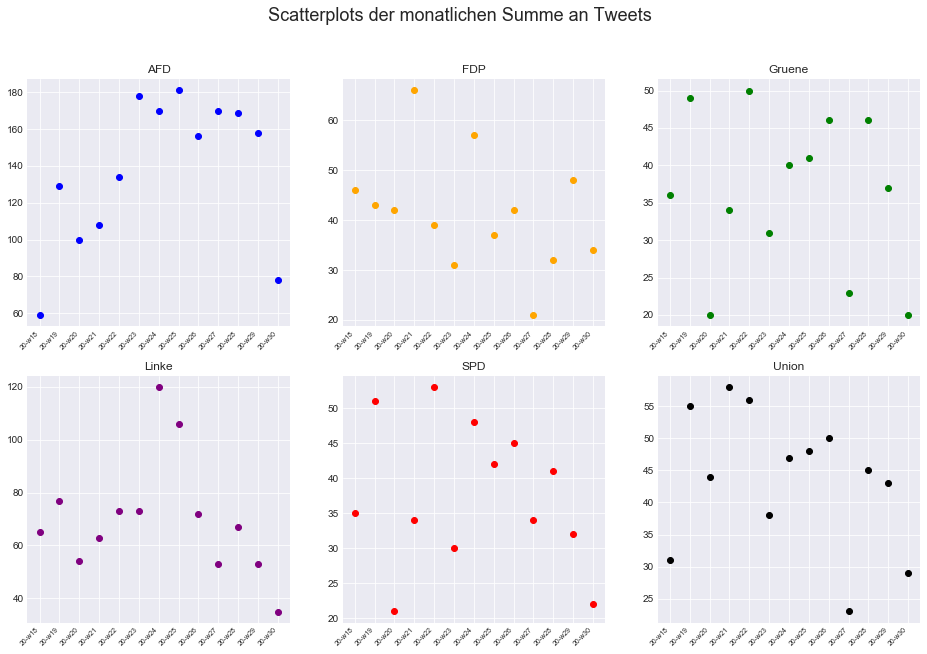

In [101]:
from matplotlib import pyplot
datensatz = after_Corona_dic['piv_weekOFFENSE']
pyplot.style.use('seaborn-darkgrid')
my_palette = ['blue', 'orange', 'green', 'purple', 'red', 'black']

fig = pyplot.figure(figsize = (16,10))
fig.suptitle('Scatterplots der monatlichen Summe an Tweets', fontsize = 18)

num = 0
for party, n in zip(Corona_dic['piv_date'].columns, range(1,7)):
    ax = fig.add_subplot(2,3,n)
    ax.scatter(datensatz.index, datensatz[party], color = my_palette[num])
    x_tags = pyplot.xticks(datensatz.index, fontsize = 7, rotation = 45, ha = "right")
    ax.set_title(party)
    num = num + 1

### Histograme

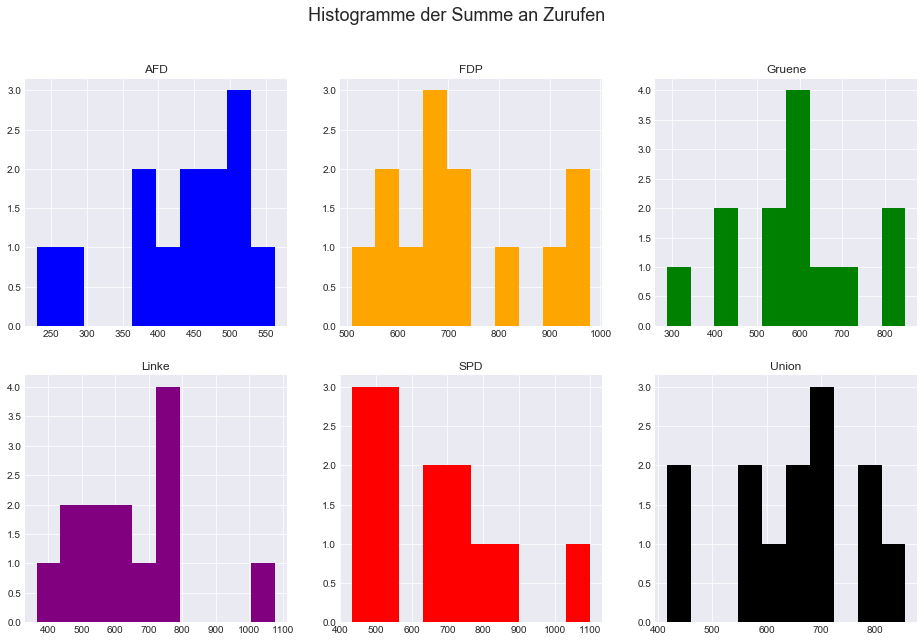

In [102]:
datensatz =  after_Corona_dic['piv_week']
pyplot.style.use('seaborn-darkgrid')
my_palette = ['blue', 'orange', 'green', 'purple', 'red', 'black']
Parteien = ['AFD', 'FDP', 'Gruene', 'Linke', 'SPD', 'Union']

fig = pyplot.figure(figsize = (16,10))
fig.suptitle('Histogramme der Summe an Zurufen', fontsize = 18)

num = 0
for party, n in zip(Corona_dic['piv_week'].columns, range(1,7)):
    ax = fig.add_subplot(2,3,n)
    ax.hist(datensatz[party], color = my_palette[num])
    ax.set_title(party)
    num = num + 1


### Shapiro-Wilk

In [103]:
from scipy.stats import shapiro

partei = []
dataset = []
result = []
dic = after_Corona_dic

for party in Corona_dic['piv_date'].columns:
    for dat in dic.keys():
        partei.append(party)
        dataset.append(dat)
# normality test H0: Dataset frwan from Gausian distribution
        stat, p = shapiro(dic[dat][party])

        alpha = 0.05
        if p > alpha:
            result.append('Stats=%.3f, p=%.3f' % (stat, p) + ' Gaussian') # Weise H0 nicht zurück
        else:
            result.append('Stats=%.3f, p=%.3f' % (stat, p) + ' NOT Gaussian')
            
Shapiro_Wilk_Corona_df = pd.DataFrame({'Partei':partei, 'Daten':dataset, 'Ergebnis':result})
Shapiro_Wilk_Corona_piv = pd.pivot_table(Shapiro_Wilk_Corona_df, values='Ergebnis', index=['Daten'], columns=['Partei'], aggfunc=max)
Shapiro_Wilk_Corona_piv

Partei,AFD,FDP,Gruene,Linke,SPD,Union
Daten,,,,,,
piv_date,"Stats=0.976, p=0.112 Gaussian","Stats=0.971, p=0.048 NOT Gaussian","Stats=0.951, p=0.003 NOT Gaussian","Stats=0.950, p=0.002 NOT Gaussian","Stats=0.908, p=0.000 NOT Gaussian","Stats=0.952, p=0.003 NOT Gaussian"
piv_dateOFFENSE,"Stats=0.909, p=0.000 NOT Gaussian","Stats=0.922, p=0.000 NOT Gaussian","Stats=0.864, p=0.000 NOT Gaussian","Stats=0.851, p=0.000 NOT Gaussian","Stats=0.933, p=0.000 NOT Gaussian","Stats=0.963, p=0.015 NOT Gaussian"
piv_dateOTHER,"Stats=0.977, p=0.122 Gaussian","Stats=0.965, p=0.019 NOT Gaussian","Stats=0.951, p=0.003 NOT Gaussian","Stats=0.953, p=0.003 NOT Gaussian","Stats=0.907, p=0.000 NOT Gaussian","Stats=0.950, p=0.002 NOT Gaussian"
piv_month,"Stats=0.884, p=0.337 Gaussian","Stats=0.799, p=0.111 Gaussian","Stats=0.789, p=0.088 Gaussian","Stats=0.898, p=0.378 Gaussian","Stats=0.965, p=0.641 Gaussian","Stats=0.770, p=0.046 NOT Gaussian"
piv_monthOFFENSE,"Stats=0.900, p=0.385 Gaussian","Stats=0.960, p=0.618 Gaussian","Stats=0.959, p=0.612 Gaussian","Stats=0.775, p=0.056 Gaussian","Stats=0.989, p=0.797 Gaussian","Stats=0.942, p=0.537 Gaussian"
piv_monthOTHER,"Stats=0.869, p=0.294 Gaussian","Stats=0.851, p=0.244 Gaussian","Stats=0.817, p=0.156 Gaussian","Stats=0.927, p=0.476 Gaussian","Stats=0.964, p=0.636 Gaussian","Stats=0.766, p=0.035 NOT Gaussian"
piv_week,"Stats=0.913, p=0.199 Gaussian","Stats=0.917, p=0.231 Gaussian","Stats=0.973, p=0.925 Gaussian","Stats=0.945, p=0.531 Gaussian","Stats=0.918, p=0.234 Gaussian","Stats=0.955, p=0.683 Gaussian"
piv_weekOFFENSE,"Stats=0.892, p=0.105 Gaussian","Stats=0.969, p=0.882 Gaussian","Stats=0.921, p=0.263 Gaussian","Stats=0.903, p=0.149 Gaussian","Stats=0.957, p=0.711 Gaussian","Stats=0.945, p=0.521 Gaussian"
piv_weekOTHER,"Stats=0.937, p=0.419 Gaussian","Stats=0.936, p=0.403 Gaussian","Stats=0.970, p=0.890 Gaussian","Stats=0.954, p=0.654 Gaussian","Stats=0.910, p=0.181 Gaussian","Stats=0.951, p=0.618 Gaussian"


In [104]:
contingency_Corona = pd.pivot_table(sent_after_Corona, index = 'user_party', columns = 'predict', aggfunc=np.count_nonzero)['full_text']
contingency_Corona

predict,OFFENSE,OTHER
user_party,,
AFD,1790,3863
FDP,538,8937
Gruene,473,7199
Linke,911,7468
SPD,488,8106
Union,567,7841


In [105]:
from scipy.stats import chi2_contingency
stat, p, dof, expected = chi2_contingency(contingency_Corona)
print('stat=%.3f, p=%.3f' % (stat, p))

if p > 0.05:
    print('Probably independent')
else:
    print('Probably dependent')
# Häufigkeit OFFENSE oder OTHER ist abhängig von der Partei 

stat=3587.829, p=0.000
Probably dependent


In [106]:
# Normiere OFFENSE Tweets
before_Corona_rel_piv = (before_Corona_dic['piv_dateOFFENSE'] / before_Corona_dic['piv_date'])*100
# Wenn before_Corona mit Wochenintervallen -> SPD ist nicht signifikant weniger während Lockdown
Corona_rel_piv = ((Corona_dic['piv_dateOFFENSE']/ Corona_dic['piv_date'])*100).fillna(0)
after_Corona_rel_piv = ((after_Corona_dic['piv_dateOFFENSE']/ after_Corona_dic['piv_date'])*100).fillna(0)

In [117]:
## T-Test eigentlich schlecht - weil nicht normalverteilt!

from scipy.stats import ttest_ind
partei = []
result = []    

for party in before_Corona_rel_piv.columns:
        partei.append(party)
# normality test
        stat, p = ttest_ind(before_Corona_rel_piv[party], Corona_rel_piv[party])
        if p/2 > 0.05 or stat < 0:    # p/2 für Einseitigen t-Test
            result.append('stat=%.3f, p=%.3f' % (stat, p) + ' Gleich oder mehr als vor dem Lockdown' )
        else:
            result.append('stat=%.3f, p=%.3f' % (stat, p) + ' WENIGER als vor dem Lockdown')
          
                        
H03_bef_Corona_df = pd.DataFrame({'Partei':partei, 'Ergebnis':result})
H03_bef_Corona_df

,Partei,Ergebnis
0,AFD,"stat=7.180, p=0.000 WENIGER als vor dem Lockdown"
1,FDP,"stat=3.658, p=0.000 WENIGER als vor dem Lockdown"
2,Gruene,"stat=4.632, p=0.000 WENIGER als vor dem Lockdown"
3,Linke,"stat=7.395, p=0.000 WENIGER als vor dem Lockdown"
4,SPD,"stat=1.570, p=0.117 Gleich oder mehr als vor d..."
5,Union,"stat=2.409, p=0.017 WENIGER als vor dem Lockdown"


In [100]:
# Example of the Mann-Whitney U Test
from scipy.stats import mannwhitneyu

partei = []
result = []

for party in before_Corona_rel_piv.columns:
        partei.append(party)
# normality test
        stat, p = mannwhitneyu(before_Corona_rel_piv[party], Corona_rel_piv[party])
        if p/2 > 0.05:
            result.append('stat=%.3f, p=%.3f' % (stat, p) + ' Gleich oder mehr als vor dem Lockdown')
        else:
            result.append('stat=%.3f, p=%.3f' % (stat, p) + ' WENIGER als vor dem Lockdown')

          
Mann_Whitney_df = pd.DataFrame({'Partei':partei, 'Ergebnis':result})
Mann_Whitney_df

,Partei,Ergebnis
0,AFD,"stat=3566.500, p=0.000 WENIGER als vor dem Loc..."
1,FDP,"stat=5770.000, p=0.000 WENIGER als vor dem Loc..."
2,Gruene,"stat=4568.500, p=0.000 WENIGER als vor dem Loc..."
3,Linke,"stat=2579.000, p=0.000 WENIGER als vor dem Loc..."
4,SPD,"stat=7722.500, p=0.148 Gleich oder mehr als vo..."
5,Union,"stat=7042.500, p=0.023 WENIGER als vor dem Loc..."


# H03: Die Häufigkeit von OFFENSE-Tweets während dem Corona Lockdown unterscheidet sich NICHT von der nach dem Lockdown.

In [109]:
## T-Test eigentlich schlecht - weil nicht normalverteilt!

from scipy.stats import ttest_ind
partei = []
result = []    

for party in after_Corona_rel_piv.columns:
        partei.append(party)
# normality test
        stat, p = ttest_ind(after_Corona_rel_piv[party], Corona_rel_piv[party])
        if p/2 > 0.05 or stat < 0:    # p/2 für Einseitigen t-Test
            result.append('stat=%.3f, p=%.3f' % (stat, p) + ' Gleich oder mehr als nach dem Lockdown' )
        else:
            result.append('stat=%.3f, p=%.3f' % (stat, p) + ' WENIGER als nach dem Lockdown')
          
                        
H03_bef_Corona_df = pd.DataFrame({'Partei':partei, 'Ergebnis':result})
H03_bef_Corona_df

,Partei,Ergebnis
0,AFD,"stat=4.528, p=0.000 WENIGER als nach dem Lockdown"
1,FDP,"stat=3.535, p=0.001 WENIGER als nach dem Lockdown"
2,Gruene,"stat=4.372, p=0.000 WENIGER als nach dem Lockdown"
3,Linke,"stat=5.809, p=0.000 WENIGER als nach dem Lockdown"
4,SPD,"stat=2.236, p=0.027 WENIGER als nach dem Lockdown"
5,Union,"stat=2.873, p=0.005 WENIGER als nach dem Lockdown"


In [110]:
# Example of the Mann-Whitney U Test
from scipy.stats import mannwhitneyu

partei = []
result = []

for party in after_Corona_rel_piv.columns:
        partei.append(party)
# normality test
        stat, p = mannwhitneyu(after_Corona_rel_piv[party], Corona_rel_piv[party])
        if p/2 > 0.05:
            result.append('stat=%.3f, p=%.3f' % (stat, p) + ' Gleich oder mehr als nach dem Lockdown')
        else:
            result.append('stat=%.3f, p=%.3f' % (stat, p) + ' WENIGER als nach dem Lockdown')

          
Mann_Whitney_df = pd.DataFrame({'Partei':partei, 'Ergebnis':result})
Mann_Whitney_df

,Partei,Ergebnis
0,AFD,"stat=1316.000, p=0.000 WENIGER als nach dem Lo..."
1,FDP,"stat=1579.500, p=0.001 WENIGER als nach dem Lo..."
2,Gruene,"stat=1310.000, p=0.000 WENIGER als nach dem Lo..."
3,Linke,"stat=997.500, p=0.000 WENIGER als nach dem Loc..."
4,SPD,"stat=1881.000, p=0.030 WENIGER als nach dem Lo..."
5,Union,"stat=1660.500, p=0.002 WENIGER als nach dem Lo..."


# H04: Die Häufigkeit von OFFENSE-Tweets vor dem Corona Lockdown unterscheidet sich NICHT von der nach dem Lockdown.

In [130]:
before_Corona_rel_piv = (before_Corona_dic['piv_dateOFFENSE'] / before_Corona_dic['piv_date'])*100
after_Corona_rel_piv = ((after_Corona_dic['piv_dateOFFENSE']/ after_Corona_dic['piv_date'])*100).fillna(0)
bef_Corona_rel_piv = before_Corona_rel_piv[228:]

In [129]:
len(before_Corona_rel_piv) - len(after_Corona_rel_piv)
len(before_Corona_rel_piv[228:])

86

In [131]:
from scipy.stats import ttest_rel
partei = []
result = []    

for party in after_Corona_rel_piv.columns:
        partei.append(party)
# normality test
        stat, p = ttest_rel(after_Corona_rel_piv[party], bef_Corona_rel_piv[party])
        if p > 0.05:    
            result.append('stat=%.3f, p=%.3f' % (stat, p) + ' Gleiche Häufigkeit vor und nach dem Lockdown' )
        else:
            result.append('stat=%.3f, p=%.3f' % (stat, p) + ' Andere Häufigkeiten vor und nach dem Lockdown')
          
                        
H04_Corona_df = pd.DataFrame({'Partei':partei, 'Ergebnis':result})
H04_Corona_df

,Partei,Ergebnis
0,AFD,"stat=-5.121, p=0.000 Andere Häufigkeiten vor u..."
1,FDP,"stat=-3.351, p=0.001 Andere Häufigkeiten vor u..."
2,Gruene,"stat=-2.712, p=0.008 Andere Häufigkeiten vor u..."
3,Linke,"stat=-3.778, p=0.000 Andere Häufigkeiten vor u..."
4,SPD,"stat=-1.276, p=0.205 Gleiche Häufigkeit vor un..."
5,Union,"stat=-2.690, p=0.009 Andere Häufigkeiten vor u..."


In [113]:
# Example of the Mann-Whitney U Test
from scipy.stats import mannwhitneyu

partei = []
result = []

for party in after_Corona_rel_piv.columns:
        partei.append(party)
# normality test
        stat, p = mannwhitneyu(after_Corona_rel_piv[party], before_Corona_rel_piv[party])
        if p > 0.05:
            result.append('stat=%.3f, p=%.3f' % (stat, p) + ' Gleiche Häufigkeit vor und nach dem Lockdown' )
        else:
            result.append('stat=%.3f, p=%.3f' % (stat, p) + ' Andere Häufigkeiten vor und nach dem Lockdown')

          
Mann_Whitney_df = pd.DataFrame({'Partei':partei, 'Ergebnis':result})
Mann_Whitney_df

,Partei,Ergebnis
0,AFD,"stat=9865.000, p=0.000 Andere Häufigkeiten vor..."
1,FDP,"stat=13424.500, p=0.468 Gleiche Häufigkeit vor..."
2,Gruene,"stat=12704.000, p=0.201 Gleiche Häufigkeit vor..."
3,Linke,"stat=10965.000, p=0.004 Andere Häufigkeiten vo..."
4,SPD,"stat=12254.500, p=0.095 Gleiche Häufigkeit vor..."
5,Union,"stat=12330.500, p=0.109 Gleiche Häufigkeit vor..."


# Plenum

In [39]:
import pickle, gensim, numpy as np
import pandas as pd 

#df_kom = mdp_partei_emo
PICKLE_FOLDER_PATH = '/home/lisa/Darmstadt/Master Arbeit/06_Analyse/Plenum/'
#pickle.dump(df_kom, open(PICKLE_FOLDER_PATH + 'Plenum_Kom_all_Sent', "wb" ))

df_kom = pickle.load(open(PICKLE_FOLDER_PATH + 'Plenum_Kom_all_Sent', "rb" ))

In [40]:
import pandas as pd
time = ['Monat', 'Woche', 'date_str']
cat = ['', 'OFFENSE', 'OTHER']
plenum_dic = {}


for c in cat: 
    if c == '':
        sent_df = df_kom
    else:
        sent_df = df_kom.loc[df_kom['predict'] == c]
    for t in time: 
        piv = pd.pivot_table(sent_df, index = [t], columns = ['Partei'], aggfunc = np.count_nonzero)['Beschreibung1'].fillna(0)
        
        plenum_dic['piv_'+t+c] =  piv       

        
        
# Lösche NaNs aus dem Datensatz ########

#for dat in plenum_dic.keys():
#    for party in plenum_dic['piv_Monat'].columns:
#        plenum_dic[dat] = plenum_dic[dat].loc[plenum_dic[dat][party].isnull() == False]
        
plenum_dic.keys()

dict_keys(['piv_Monat', 'piv_Woche', 'piv_date_str', 'piv_MonatOFFENSE', 'piv_WocheOFFENSE', 'piv_date_strOFFENSE', 'piv_MonatOTHER', 'piv_WocheOTHER', 'piv_date_strOTHER'])

In [ ]:
# Lösche Daten die nicht auch in OFFENSE piv sind
for date in ['2017-10-24', '2018-01-17', '2018-03-14', '2018-11-28', '2019-01-16', '2020-01-15']:
    plenum_dic['piv_date_str'] = plenum_dic['piv_date_str'].loc[plenum_dic['piv_date_str'].index != date]

# Normiere OFFENSE Tweets
twitter_rel_piv = (twitter_dic['piv_weekOFFENSE'] / twitter_dic['piv_week'])*100
plenum_rel_piv = ((plenum_dic['piv_date_strOFFENSE'][97:] / plenum_dic['piv_date_str'][97:])*100).fillna(0)

# Nur alle Tweets - richtiger Ausschnitt
# twitter_rel_piv = twitter_dic['piv_week']
# plenum_rel_piv = plenum_dic['piv_date_str'][97:]

In [41]:
pd.set_option('display.max_rows', None)
df1 = pd.pivot_table(df_kom.loc[df_kom['predict'] == 'OTHER'], index = 'date_str', columns = ['Partei'], aggfunc = np.count_nonzero)['Beschreibung1'].fillna(0)
df2 = pd.pivot_table(df_kom.loc[df_kom['predict'] == 'OFFENSE'], index = 'date_str', columns = ['Partei'], aggfunc = np.count_nonzero)['Beschreibung1'].fillna(0)

for x in df1.index:
    if x in df2.index:
        continue
    else:
        print(x)

2017-10-24
2018-01-17
2018-03-14
2018-11-28
2019-01-16
2020-01-15


In [511]:
#pd.pivot_table(df_kom, index = 'date_str', columns = ['Partei'], aggfunc = np.count_nonzero)['Beschreibung1'].fillna(0)
pd.pivot_table(df_kom.loc[df_kom['predict'] == 'OFFENSE'], index = 'date_str', columns = ['Partei'], aggfunc = np.count_nonzero)['Beschreibung1'].fillna(0)
#pd.pivot_table(df_kom.loc[df_kom['predict'] == 'OTHER'], index = 'date_str', columns = ['Partei'], aggfunc = np.count_nonzero)['Beschreibung1'].fillna(0)
#plenum_dic['piv_date_strOFFENSE']

Partei,AfD,BÜNDNIS_90/DIE_GRÜNEN,CDU/CSU,DIE_LINKE,FDP,SPD
date_str,,,,,,
2017-11-21,1.0,0.0,3.0,1.0,1.0,1.0
2017-11-22,0.0,2.0,0.0,0.0,0.0,0.0
2017-12-12,1.0,1.0,2.0,2.0,0.0,4.0
2017-12-13,11.0,1.0,0.0,0.0,0.0,3.0
2018-01-18,3.0,2.0,1.0,0.0,0.0,9.0
2018-01-19,2.0,3.0,1.0,1.0,0.0,1.0
2018-01-22,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-31,0.0,0.0,0.0,0.0,1.0,0.0
2018-02-01,5.0,2.0,4.0,8.0,1.0,1.0


# Check for Normality

In [173]:
# https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/
# generate gaussian data
from numpy.random import seed
from numpy.random import randn
from numpy import mean
from numpy import std
# seed the random number generator
seed(1)
# generate univariate observations
data = 5 * randn(100) + 50

# summarize
print('mean=%.3f stdv=%.3f' % (mean(data), std(data)))
print('mean=%.3f stdv=%.3f' % (mean(plenum_dic['piv_Monat']['FDP']), std(plenum_dic['piv_Monat']['AfD'])))

mean=50.303 stdv=4.426
mean=231.688 stdv=195.793


In [44]:
durch = []
abw = []
partei = []
daten = []

for dat, n in zip(plenum_dic, plenum_dic.keys()):
    for party in plenum_dic['piv_Monat'].columns:
        daten.append(n)
        partei.append(party)
        durch.append(mean(plenum_dic[dat][party]).round())
        abw.append(std(plenum_dic[dat][party]))

plenum_mean_std = pd.DataFrame({'Datensatz': daten, 'Partei': partei, 'Mean': durch, 'Std': abw})
#plenum_mean_std

### Scatterplots

In [50]:
plenum_dic.keys()

dict_keys(['piv_Monat', 'piv_Woche', 'piv_date_str', 'piv_MonatOFFENSE', 'piv_WocheOFFENSE', 'piv_date_strOFFENSE', 'piv_MonatOTHER', 'piv_WocheOTHER', 'piv_date_strOTHER'])

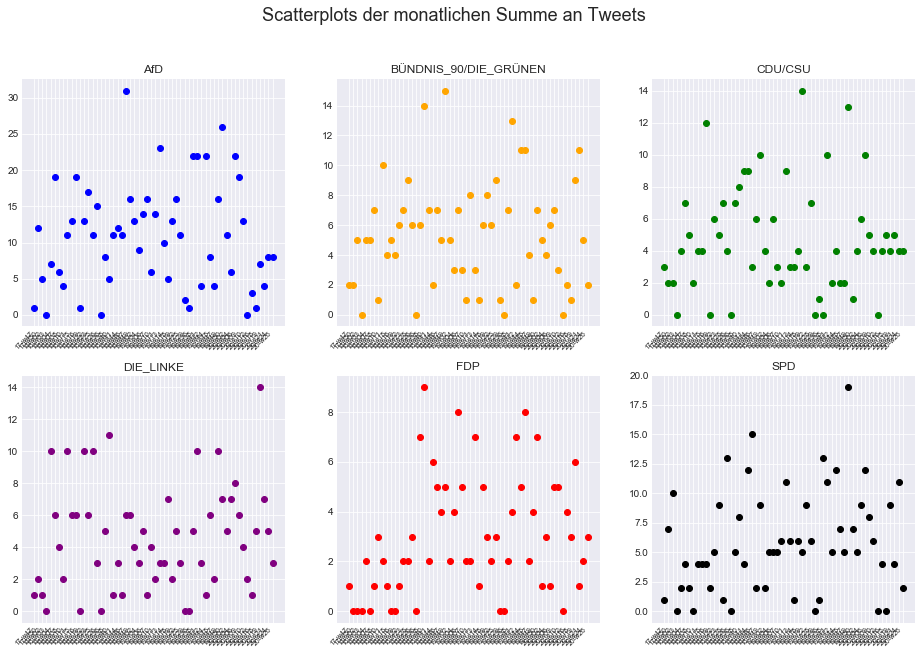

In [51]:
from matplotlib import pyplot
datensatz = plenum_dic['piv_WocheOFFENSE']
pyplot.style.use('seaborn-darkgrid')
my_palette = ['blue', 'orange', 'green', 'purple', 'red', 'black']

fig = pyplot.figure(figsize = (16,10))
fig.suptitle('Scatterplots der monatlichen Summe an Tweets', fontsize = 18)

num = 0
for party, n in zip(plenum_dic['piv_Monat'].columns, range(1,7)):
    ax = fig.add_subplot(2,3,n)
    ax.scatter(datensatz.index, datensatz[party], color = my_palette[num])
    x_tags = pyplot.xticks(datensatz.index, fontsize = 7, rotation = 45, ha = "right")
    ax.set_title(party)
    num = num + 1

### Histograme

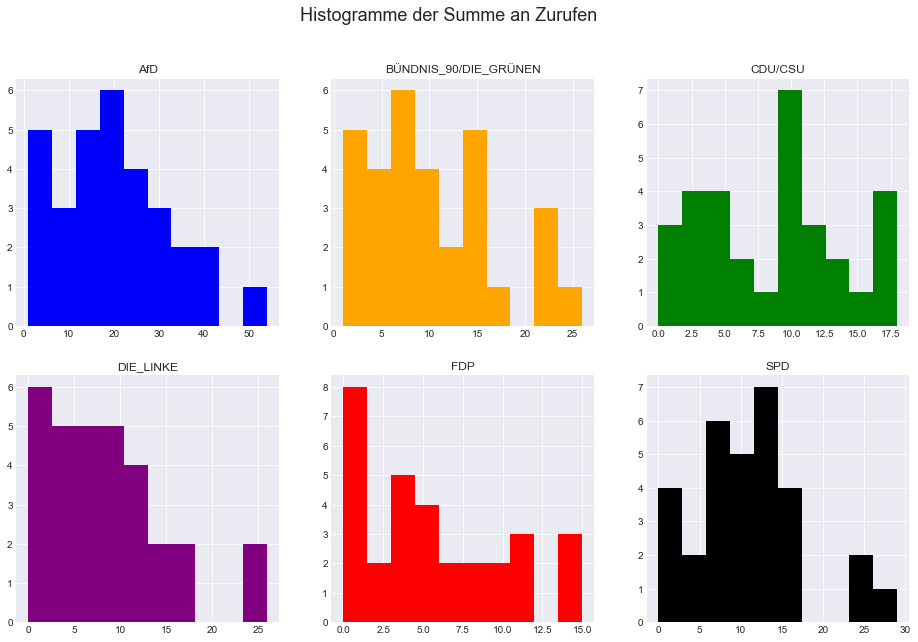

In [54]:
datensatz =  plenum_dic['piv_WocheOFFENSE']
pyplot.style.use('seaborn-darkgrid')
my_palette = ['blue', 'orange', 'green', 'purple', 'red', 'black']
Parteien = ['AFD', 'FDP', 'Gruene', 'Linke', 'SPD', 'Union']

fig = pyplot.figure(figsize = (16,10))
fig.suptitle('Histogramme der Summe an Zurufen', fontsize = 18)

num = 0
for party, n in zip(plenum_dic['piv_date_str'].columns, range(1,7)):
    ax = fig.add_subplot(2,3,n)
    ax.hist(datensatz[party], color = my_palette[num])
    ax.set_title(party)
    num = num + 1


In [254]:
plenum_dic.keys()

dict_keys(['piv_Monat', 'piv_Woche', 'piv_date_str', 'piv_MonatOFFENSE', 'piv_WocheOFFENSE', 'piv_date_strOFFENSE', 'piv_MonatOTHER', 'piv_WocheOTHER', 'piv_date_strOTHER'])

### Shapiro-Wilk

In [60]:
from scipy.stats import shapiro

partei = []
dataset = []
result = []

for party in plenum_dic['piv_date_str'].columns:
    for dat in plenum_dic.keys():
        partei.append(party)
        dataset.append(dat)
# normality test
        stat, p = shapiro(plenum_dic[dat][party])

        alpha = 0.05
        if p > alpha:
            result.append('Stats=%.3f, p=%.3f' % (stat, p) + ' Gaussian')
        else:
            result.append('Stats=%.3f, p=%.3f' % (stat, p) + ' NOT Gaussian')
            
Shapiro_Wilk_plen_df = pd.DataFrame({'Partei':partei, 'Daten':dataset, 'Ergebnis':result})
Shapiro_Wilk_plen_piv = pd.pivot_table(Shapiro_Wilk_plen_df, values='Ergebnis', index=['Daten'], columns=['Partei'], aggfunc=max)
Shapiro_Wilk_plen_piv

Partei,AfD,BÜNDNIS_90/DIE_GRÜNEN,CDU/CSU,DIE_LINKE,FDP,SPD
Daten,,,,,,
piv_Monat,"Stats=0.963, p=0.334 Gaussian","Stats=0.966, p=0.394 Gaussian","Stats=0.961, p=0.287 Gaussian","Stats=0.972, p=0.552 Gaussian","Stats=0.955, p=0.201 Gaussian","Stats=0.949, p=0.139 Gaussian"
piv_MonatOFFENSE,"Stats=0.966, p=0.417 Gaussian","Stats=0.930, p=0.044 NOT Gaussian","Stats=0.948, p=0.134 Gaussian","Stats=0.905, p=0.010 NOT Gaussian","Stats=0.910, p=0.013 NOT Gaussian","Stats=0.944, p=0.105 Gaussian"
piv_MonatOTHER,"Stats=0.963, p=0.331 Gaussian","Stats=0.966, p=0.397 Gaussian","Stats=0.959, p=0.264 Gaussian","Stats=0.973, p=0.583 Gaussian","Stats=0.955, p=0.203 Gaussian","Stats=0.950, p=0.141 Gaussian"
piv_Woche,"Stats=0.956, p=0.031 NOT Gaussian","Stats=0.938, p=0.005 NOT Gaussian","Stats=0.958, p=0.039 NOT Gaussian","Stats=0.938, p=0.005 NOT Gaussian","Stats=0.982, p=0.527 Gaussian","Stats=0.981, p=0.498 Gaussian"
piv_WocheOFFENSE,"Stats=0.964, p=0.079 Gaussian","Stats=0.951, p=0.021 NOT Gaussian","Stats=0.928, p=0.002 NOT Gaussian","Stats=0.938, p=0.005 NOT Gaussian","Stats=0.921, p=0.001 NOT Gaussian","Stats=0.945, p=0.011 NOT Gaussian"
piv_WocheOTHER,"Stats=0.955, p=0.028 NOT Gaussian","Stats=0.937, p=0.004 NOT Gaussian","Stats=0.959, p=0.044 NOT Gaussian","Stats=0.933, p=0.003 NOT Gaussian","Stats=0.982, p=0.535 Gaussian","Stats=0.980, p=0.420 Gaussian"
piv_date_str,"Stats=0.894, p=0.000 NOT Gaussian","Stats=0.944, p=0.000 NOT Gaussian","Stats=0.931, p=0.000 NOT Gaussian","Stats=0.938, p=0.000 NOT Gaussian","Stats=0.909, p=0.000 NOT Gaussian","Stats=0.921, p=0.000 NOT Gaussian"
piv_date_strOFFENSE,"Stats=0.814, p=0.000 NOT Gaussian","Stats=0.855, p=0.000 NOT Gaussian","Stats=0.737, p=0.000 NOT Gaussian","Stats=0.798, p=0.000 NOT Gaussian","Stats=0.752, p=0.000 NOT Gaussian","Stats=0.794, p=0.000 NOT Gaussian"
piv_date_strOTHER,"Stats=0.895, p=0.000 NOT Gaussian","Stats=0.943, p=0.000 NOT Gaussian","Stats=0.930, p=0.000 NOT Gaussian","Stats=0.938, p=0.000 NOT Gaussian","Stats=0.910, p=0.000 NOT Gaussian","Stats=0.921, p=0.000 NOT Gaussian"


In [56]:
contingency_plenum = pd.pivot_table(df_kom, index = 'Partei', columns = 'predict', aggfunc=np.count_nonzero)['Beschreibung1']

In [57]:
from scipy.stats import chi2_contingency
stat, p, dof, expected = chi2_contingency(contingency_plenum)
print('stat=%.3f, p=%.3f' % (stat, p))

if p > 0.05:
    print('Probably independent')
else:
    print('Probably dependent')

stat=209.948, p=0.000
Probably dependent


# H04: Die Mitglieder der AfD rufen im Parlament höchstens genauso oft OFFENSE-Zurufe hinein wie die Mitglieder jeder anderen Partei.

In [61]:
from scipy.stats import ttest_ind
partei = []
dataset = []
result = []    

for party in plenum_dic['piv_date_str'].columns:
    for dat in plenum_dic.keys():
        partei.append(party)
        dataset.append(dat)
# normality test
        stat, p = ttest_ind(plenum_dic[dat]['AfD'], plenum_dic[dat][party])
        if p/2 > 0.05 or stat < 0:    # p/2 für Einseitigen t-Test
            result.append('stat=%.3f, p=%.3f' % (stat, p) + ' Gleich oder mehr als AfD' )
        else:
            result.append('stat=%.3f, p=%.3f' % (stat, p) + ' WENIGER als AfD')
          
                        
H01_plen_df = pd.DataFrame({'Partei':partei, 'Daten':dataset, 'Ergebnis':result})
H01_plen_piv =  pd.pivot_table(H01_plen_df, values='Ergebnis', index=['Daten'], columns=['Partei'], aggfunc=max) 

In [62]:
# Example of the Mann-Whitney U Test
from scipy.stats import mannwhitneyu

partei = []
dataset = []
result = []

for party in plenum_dic['piv_date_str'].columns:
    for dat in plenum_dic.keys():
        partei.append(party)
        dataset.append(dat)
# normality test
        stat, p = mannwhitneyu(plenum_dic[dat]['AfD'], plenum_dic[dat][party])
        if p/2 > 0.05:
            result.append('stat=%.3f, p=%.3f' % (stat, p) + ' Gleich oder mehr als AfD' )
        else:
            result.append('stat=%.3f, p=%.3f' % (stat, p) + ' WENIGER als AfD')

          
Mann_Whitney_df = pd.DataFrame({'Partei':partei, 'Daten':dataset, 'Ergebnis':result})
Mann_Whitney_piv =  pd.pivot_table(Mann_Whitney_df, values='Ergebnis', index=['Daten'], columns=['Partei'], aggfunc=max) 
Mann_Whitney_piv

Partei,AfD,BÜNDNIS_90/DIE_GRÜNEN,CDU/CSU,DIE_LINKE,FDP,SPD
Daten,,,,,,
piv_Monat,"stat=512.000, p=0.497 Gleich oder mehr als AfD","stat=445.000, p=0.186 Gleich oder mehr als AfD","stat=436.000, p=0.155 Gleich oder mehr als AfD","stat=338.500, p=0.010 WENIGER als AfD","stat=415.000, p=0.098 WENIGER als AfD","stat=391.500, p=0.054 WENIGER als AfD"
piv_MonatOFFENSE,"stat=480.500, p=0.497 Gleich oder mehr als AfD","stat=246.000, p=0.000 WENIGER als AfD","stat=217.500, p=0.000 WENIGER als AfD","stat=213.500, p=0.000 WENIGER als AfD","stat=141.500, p=0.000 WENIGER als AfD","stat=265.500, p=0.001 WENIGER als AfD"
piv_MonatOTHER,"stat=512.000, p=0.497 Gleich oder mehr als AfD","stat=456.000, p=0.228 Gleich oder mehr als AfD","stat=453.000, p=0.216 Gleich oder mehr als AfD","stat=348.000, p=0.014 WENIGER als AfD","stat=431.000, p=0.140 Gleich oder mehr als AfD","stat=399.500, p=0.066 WENIGER als AfD"
piv_Woche,"stat=1740.500, p=0.499 Gleich oder mehr als AfD","stat=1342.000, p=0.016 WENIGER als AfD","stat=1354.000, p=0.019 WENIGER als AfD","stat=893.500, p=0.000 WENIGER als AfD","stat=1187.500, p=0.001 WENIGER als AfD","stat=1113.000, p=0.000 WENIGER als AfD"
piv_WocheOFFENSE,"stat=1682.000, p=0.499 Gleich oder mehr als AfD","stat=900.000, p=0.000 WENIGER als AfD","stat=787.000, p=0.000 WENIGER als AfD","stat=774.000, p=0.000 WENIGER als AfD","stat=547.500, p=0.000 WENIGER als AfD","stat=988.000, p=0.000 WENIGER als AfD"
piv_WocheOTHER,"stat=1740.500, p=0.499 Gleich oder mehr als AfD","stat=1411.000, p=0.038 WENIGER als AfD","stat=1412.000, p=0.039 WENIGER als AfD","stat=924.500, p=0.000 WENIGER als AfD","stat=1268.000, p=0.006 WENIGER als AfD","stat=1148.000, p=0.001 WENIGER als AfD"
piv_date_str,"stat=14450.000, p=0.500 Gleich oder mehr als AfD","stat=13889.500, p=0.268 Gleich oder mehr als AfD","stat=13802.500, p=0.237 Gleich oder mehr als AfD","stat=11947.000, p=0.003 WENIGER als AfD","stat=13017.000, p=0.057 WENIGER als AfD","stat=12675.500, p=0.025 WENIGER als AfD"
piv_date_strOFFENSE,"stat=13448.000, p=0.500 Gleich oder mehr als AfD","stat=10596.000, p=0.000 WENIGER als AfD","stat=9627.000, p=0.000 WENIGER als AfD","stat=9770.500, p=0.000 WENIGER als AfD","stat=8128.500, p=0.000 WENIGER als AfD","stat=10610.000, p=0.000 WENIGER als AfD"
piv_date_strOTHER,"stat=14450.000, p=0.500 Gleich oder mehr als AfD","stat=14049.500, p=0.329 Gleich oder mehr als AfD","stat=14018.000, p=0.317 Gleich oder mehr als AfD","stat=12081.000, p=0.004 WENIGER als AfD","stat=13286.500, p=0.099 WENIGER als AfD","stat=12757.500, p=0.031 WENIGER als AfD"


### Überprüfung mit relativen Werten

In [577]:
## T-Test eigentlich schlecht - weil nicht normalverteilt!

from scipy.stats import ttest_ind
partei = []
result = []    

for party in plenum_rel_piv.columns:
        partei.append(party)
# normality test
        stat, p = ttest_ind(plenum_rel_piv['AfD'], plenum_rel_piv[party])
        if p/2 > 0.05 or stat < 0:    # p/2 für Einseitigen t-Test
            result.append('stat=%.3f, p=%.3f' % (stat, p) + ' Gleich oder mehr als AfD' )
        else:
            result.append('stat=%.3f, p=%.3f' % (stat, p) + ' WENIGER als AfD')
          
                        
H01_plen_df = pd.DataFrame({'Partei':partei, 'Ergebnis':result})
H01_plen_df

,Partei,Ergebnis
0,AfD,"stat=0.000, p=1.000 Gleich oder mehr als AfD"
1,BÜNDNIS_90/DIE_GRÜNEN,"stat=2.239, p=0.027 WENIGER als AfD"
2,CDU/CSU,"stat=2.344, p=0.021 WENIGER als AfD"
3,DIE_LINKE,"stat=1.086, p=0.279 Gleich oder mehr als AfD"
4,FDP,"stat=2.951, p=0.004 WENIGER als AfD"
5,SPD,"stat=1.035, p=0.303 Gleich oder mehr als AfD"


In [580]:
# Example of the Mann-Whitney U Test
from scipy.stats import mannwhitneyu

partei = []
result = []

for party in plenum_rel_piv.columns:
        partei.append(party)
# normality test
        stat, p = mannwhitneyu(plenum_rel_piv['AfD'], plenum_rel_piv[party])
        if p/2 > 0.05:
            result.append('stat=%.3f, p=%.3f' % (stat, p) + ' Gleich oder mehr als AfD')
        else:
            result.append('stat=%.3f, p=%.3f' % (stat, p) + ' WENIGER als AfD')

          
Mann_Whitney_df = pd.DataFrame({'Partei':partei, 'Ergebnis':result})
Mann_Whitney_df

,Partei,Ergebnis
0,AfD,"stat=2244.500, p=0.499 Gleich oder mehr als AfD"
1,BÜNDNIS_90/DIE_GRÜNEN,"stat=1558.000, p=0.001 WENIGER als AfD"
2,CDU/CSU,"stat=1576.500, p=0.001 WENIGER als AfD"
3,DIE_LINKE,"stat=1966.000, p=0.106 Gleich oder mehr als AfD"
4,FDP,"stat=1278.500, p=0.000 WENIGER als AfD"
5,SPD,"stat=2031.000, p=0.169 Gleich oder mehr als AfD"


# H05: Die Mitglieder jeder Partei rufen im Plenum höchstens genauso oft OFFENSE-Zurufe hinein wie sie OFFENSE-Tweets absetzen.

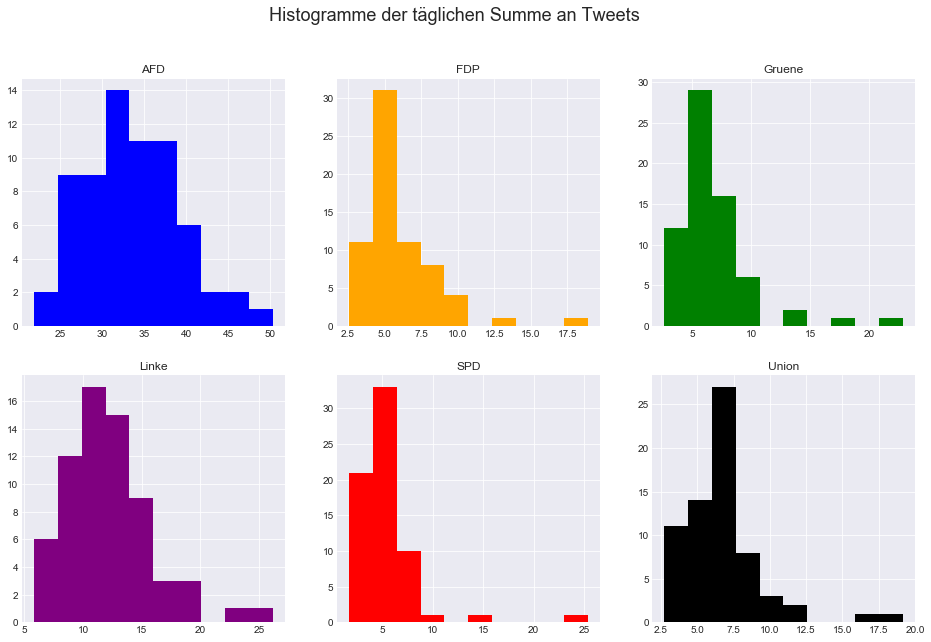

In [572]:
datensatz = twitter_rel_piv
pyplot.style.use('seaborn-darkgrid')
my_palette = ['blue', 'orange', 'green', 'purple', 'red', 'black']
Parteien = ['AFD', 'FDP', 'Gruene', 'Linke', 'SPD', 'Union']

fig = pyplot.figure(figsize = (16,10))
fig.suptitle('Histogramme der täglichen Summe an Tweets', fontsize = 18)

num = 0
for party, n in zip(datensatz.columns, range(1,7)):
    ax = fig.add_subplot(2,3,n)
    ax.hist(datensatz[party], color = my_palette[num])
    ax.set_title(party)
    num = num + 1

In [570]:
from scipy.stats import shapiro
dataset = plenum_rel_piv
partei = []
result = []

for party in dataset.columns:
        partei.append(party)
# normality test
        stat, p = shapiro(dataset[party])

        alpha = 0.05
        if p > alpha:
            result.append('Stats=%.3f, p=%.3f' % (stat, p) + ' Gaussian')
        else:
            result.append('Stats=%.3f, p=%.3f' % (stat, p) + ' NOT Gaussian')
            
Shapiro_Wilk_plen_df = pd.DataFrame({'Partei':partei, 'Ergebnis':result})
Shapiro_Wilk_plen_df

,Partei,Ergebnis
0,AfD,"Stats=0.399, p=0.000 NOT Gaussian"
1,BÜNDNIS_90/DIE_GRÜNEN,"Stats=0.809, p=0.000 NOT Gaussian"
2,CDU/CSU,"Stats=0.842, p=0.000 NOT Gaussian"
3,DIE_LINKE,"Stats=0.818, p=0.000 NOT Gaussian"
4,FDP,"Stats=0.733, p=0.000 NOT Gaussian"
5,SPD,"Stats=0.853, p=0.000 NOT Gaussian"


In [533]:
# Lösche Daten die nicht auch in OFFENSE piv sind
for date in ['2017-10-24', '2018-01-17', '2018-03-14', '2018-11-28', '2019-01-16', '2020-01-15']:
    plenum_dic['piv_date_str'] = plenum_dic['piv_date_str'].loc[plenum_dic['piv_date_str'].index != date]

# Normiere OFFENSE Tweets
twitter_rel_piv = (twitter_dic['piv_weekOFFENSE'] / twitter_dic['piv_week'])*100
plenum_rel_piv = ((plenum_dic['piv_date_strOFFENSE'][97:] / plenum_dic['piv_date_str'][97:])*100).fillna(0)

# Nur alle Tweets - richtiger Ausschnitt
# twitter_rel_piv = twitter_dic['piv_week']
# plenum_rel_piv = plenum_dic['piv_date_str'][97:]

In [566]:
partei = []
durch = []
abw = []

for party in twitter_rel_piv.columns:
        partei.append(party)
        durch.append('Mean: '+ str(mean(twitter_rel_piv[party]).round(3)))
        abw.append('Std:'+str(std(twitter_rel_piv[party]).round(3)))
        
twitter_data_mean_std = pd.DataFrame({'Partei': partei, 'Mean': durch, 'Std': abw})
twitter_data_mean_std

,Partei,Mean,Std
0,AFD,Mean: 33.491,Std:5.833
1,FDP,Mean: 6.006,Std:2.546
2,Gruene,Mean: 6.698,Std:3.263
3,Linke,Mean: 12.091,Std:3.78
4,SPD,Mean: 5.454,Std:3.207
5,Union,Mean: 6.765,Std:2.715


In [568]:
partei = []
durch = []
abw = []

for party in plenum_rel_piv.columns:
        partei.append(party)
        durch.append('Mean: '+ str(mean(plenum_rel_piv[party]).round(3)))
        abw.append('Std:'+str(std(plenum_rel_piv[party]).round(3)))
        
plenum_data_mean_std = pd.DataFrame({'Partei': partei, 'Mean': durch, 'Std': abw})
plenum_data_mean_std

,Partei,Mean,Std
0,AfD,Mean: 6.953,Std:12.345
1,BÜNDNIS_90/DIE_GRÜNEN,Mean: 3.386,Std:3.887
2,CDU/CSU,Mean: 3.243,Std:3.587
3,DIE_LINKE,Mean: 5.138,Std:5.631
4,FDP,Mean: 2.311,Std:3.298
5,SPD,Mean: 5.231,Std:5.509


### Spearman’s Rank Correlation


*   Observations in each sample are independent and identically distributed (iid).
*   Observations in each sample can be ranked.

Für den Vergleich von Twitter und Plenardaten werden zwei verschiedene Zeiteinheiten verwendet und die Zeiträume wurden weitgehend aneinander angeglichen - eine genaue Übereinstimmung gibt es nicht, ist jedoch auch nicht sinnvoll weil Themen im Plenum keinen tagesaktuellen Bezug haben:

* Twitter - Wochen
* Plenum - Tage

Bei den Plenardaten müssen außerdem sechs Tage entfernt werden an denen es keine OFFENSE Tweets gab - andernfalls würden nicht die gleichen Tage mit OFFENSE Tweets durch alle Tweets geteilt.

In [535]:
from scipy.stats import spearmanr
from scipy.stats import pearsonr
#-> Es können technsich beide verwendet werden - nur unten Fkt. anpassen 
# Aber Spearman ist sinnvoller weil Annahme der Normalverteilung für piv_date_str nicht haltbar ist

partei = []
partei_plen = []
dataset = []
result = []

for party in twitter_dic['piv_month'].columns:
    for party_plen in plenum_dic['piv_date_str'].columns:
        partei.append(party)
        partei_plen.append(party_plen)
# normality test
        stat, p = spearmanr(twitter_rel_piv[party], plenum_rel_piv[party_plen])

        if p > 0.05:
            result.append('Stats=%.3f, p=%.3f' % (stat, p) + ' INDEPENDENT')
        else:
            result.append('Stats=%.3f, p=%.3f' % (stat, p) + 'Probably dependent')
            
Corr_parties_df = pd.DataFrame({'Partei':partei, 'Partei_Plenum':partei_plen, 'Ergebnis':result})
Corr_parties_piv =  pd.pivot_table(Corr_parties_df, values='Ergebnis', index=['Partei_Plenum'], columns=['Partei'], aggfunc=max) 
Corr_parties_piv
# -> Die Zurufe die im Parlament an den jeweiligen Sitzungstagen erfolgen sind unabbhängig von den Tweets innerhalb einer Woche 

Partei,AFD,FDP,Gruene,Linke,SPD,Union
Partei_Plenum,,,,,,
AfD,"Stats=0.050, p=0.688 INDEPENDENT","Stats=0.016, p=0.895 INDEPENDENT","Stats=-0.058, p=0.642 INDEPENDENT","Stats=-0.170, p=0.169 INDEPENDENT","Stats=0.013, p=0.919 INDEPENDENT","Stats=-0.110, p=0.376 INDEPENDENT"
BÜNDNIS_90/DIE_GRÜNEN,"Stats=0.051, p=0.679 INDEPENDENT","Stats=0.063, p=0.611 INDEPENDENT","Stats=0.017, p=0.891 INDEPENDENT","Stats=-0.078, p=0.531 INDEPENDENT","Stats=-0.047, p=0.704 INDEPENDENT","Stats=0.065, p=0.599 INDEPENDENT"
CDU/CSU,"Stats=0.159, p=0.199 INDEPENDENT","Stats=0.081, p=0.513 INDEPENDENT","Stats=-0.003, p=0.982 INDEPENDENT","Stats=-0.080, p=0.520 INDEPENDENT","Stats=0.036, p=0.773 INDEPENDENT","Stats=0.045, p=0.717 INDEPENDENT"
DIE_LINKE,"Stats=0.210, p=0.088 INDEPENDENT","Stats=0.164, p=0.186 INDEPENDENT","Stats=0.016, p=0.900 INDEPENDENT","Stats=-0.011, p=0.929 INDEPENDENT","Stats=0.103, p=0.407 INDEPENDENT","Stats=0.094, p=0.452 INDEPENDENT"
FDP,"Stats=0.046, p=0.711 INDEPENDENT","Stats=0.046, p=0.714 INDEPENDENT","Stats=0.014, p=0.913 INDEPENDENT","Stats=-0.076, p=0.539 INDEPENDENT","Stats=-0.044, p=0.721 INDEPENDENT","Stats=0.052, p=0.676 INDEPENDENT"
SPD,"Stats=0.069, p=0.581 INDEPENDENT","Stats=0.051, p=0.683 INDEPENDENT","Stats=-0.007, p=0.953 INDEPENDENT","Stats=-0.114, p=0.358 INDEPENDENT","Stats=-0.027, p=0.827 INDEPENDENT","Stats=0.020, p=0.872 INDEPENDENT"


In [539]:
from scipy.stats import ttest_ind
partei = []
partei_plen = []
dataset = []
result = []   

for party in twitter_dic['piv_month'].columns:
    for party_plen in plenum_dic['piv_date_str'].columns:
        partei.append(party)
        partei_plen.append(party_plen)
# normality test
        stat, p = ttest_ind(twitter_rel_piv[party], plenum_rel_piv[party_plen])
        if p/2 > 0.05 or stat < 0:    # p/2 für Einseitigen t-Test
            result.append('stat=%.3f, p=%.3f' % (stat, p) + ' Gleich offensiv oder mehr im Plenum' )
        else:
            result.append('stat=%.3f, p=%.3f' % (stat, p) + ' WENIGER OFFENSIV im Plenum')
          
                        
H03_df = pd.DataFrame({'Partei':partei, 'Partei_Plenum':partei_plen, 'Ergebnis':result})
H03_piv =  pd.pivot_table(H03_df, values='Ergebnis', index=['Partei_Plenum'], columns=['Partei'], aggfunc=max) 
H03_piv

Partei,AFD,FDP,Gruene,Linke,SPD,Union
Partei_Plenum,,,,,,
AfD,"stat=23.366, p=0.000 WENIGER OFFENSIV im Plenum","stat=23.500, p=0.000 WENIGER OFFENSIV im Plenum","stat=22.475, p=0.000 WENIGER OFFENSIV im Plenum","stat=22.830, p=0.000 WENIGER OFFENSIV im Plenum","stat=17.854, p=0.000 WENIGER OFFENSIV im Plenum","stat=30.244, p=0.000 WENIGER OFFENSIV im Plenum"
BÜNDNIS_90/DIE_GRÜNEN,"stat=26.028, p=0.000 WENIGER OFFENSIV im Plenum","stat=24.439, p=0.000 WENIGER OFFENSIV im Plenum","stat=23.625, p=0.000 WENIGER OFFENSIV im Plenum","stat=23.990, p=0.000 WENIGER OFFENSIV im Plenum","stat=18.414, p=0.000 WENIGER OFFENSIV im Plenum","stat=32.456, p=0.000 WENIGER OFFENSIV im Plenum"
CDU/CSU,"stat=25.336, p=0.000 WENIGER OFFENSIV im Plenum","stat=24.193, p=0.000 WENIGER OFFENSIV im Plenum","stat=23.324, p=0.000 WENIGER OFFENSIV im Plenum","stat=23.687, p=0.000 WENIGER OFFENSIV im Plenum","stat=18.262, p=0.000 WENIGER OFFENSIV im Plenum","stat=31.895, p=0.000 WENIGER OFFENSIV im Plenum"
DIE_LINKE,"stat=26.832, p=0.000 WENIGER OFFENSIV im Plenum","stat=24.779, p=0.000 WENIGER OFFENSIV im Plenum","stat=24.029, p=0.000 WENIGER OFFENSIV im Plenum","stat=24.396, p=0.000 WENIGER OFFENSIV im Plenum","stat=18.650, p=0.000 WENIGER OFFENSIV im Plenum","stat=33.102, p=0.000 WENIGER OFFENSIV im Plenum"
FDP,"stat=25.410, p=0.000 WENIGER OFFENSIV im Plenum","stat=24.255, p=0.000 WENIGER OFFENSIV im Plenum","stat=23.394, p=0.000 WENIGER OFFENSIV im Plenum","stat=23.756, p=0.000 WENIGER OFFENSIV im Plenum","stat=18.316, p=0.000 WENIGER OFFENSIV im Plenum","stat=31.954, p=0.000 WENIGER OFFENSIV im Plenum"
SPD,"stat=25.867, p=0.000 WENIGER OFFENSIV im Plenum","stat=24.428, p=0.000 WENIGER OFFENSIV im Plenum","stat=23.603, p=0.000 WENIGER OFFENSIV im Plenum","stat=23.967, p=0.000 WENIGER OFFENSIV im Plenum","stat=18.428, p=0.000 WENIGER OFFENSIV im Plenum","stat=32.326, p=0.000 WENIGER OFFENSIV im Plenum"


In [583]:
# Example of the Mann-Whitney U Test
from scipy.stats import mannwhitneyu

partei = []
partei_plen = []
dataset = []
result = []   

for party in twitter_dic['piv_month'].columns:
    for party_plen in plenum_dic['piv_date_str'].columns:
        partei.append(party)
        partei_plen.append(party_plen)
# normality test
        stat, p = mannwhitneyu(twitter_rel_piv[party], plenum_rel_piv[party_plen])
        if p/2 > 0.05 or stat < 0:    # p/2 für Einseitigen t-Test
            result.append('stat=%.3f, p=%.3f' % (stat, p) + ' Gleich offensiv oder mehr im Plenum' )
        else:
            result.append('stat=%.3f, p=%.3f' % (stat, p) + ' WENIGER OFFENSIV im Plenum')
          
                        
H03_df = pd.DataFrame({'Partei':partei, 'Partei_Plenum':partei_plen, 'Ergebnis':result})
H03_piv =  pd.pivot_table(H03_df, values='Ergebnis', index=['Partei_Plenum'], columns=['Partei'], aggfunc=max) 
H03_piv

Partei,AFD,FDP,Gruene,Linke,SPD,Union
Partei_Plenum,,,,,,
AfD,"stat=67.000, p=0.000 WENIGER OFFENSIV im Plenum","stat=2105.000, p=0.268 Gleich offensiv oder mehr im Plenum","stat=1945.000, p=0.091 WENIGER OFFENSIV im Plenum","stat=643.000, p=0.000 WENIGER OFFENSIV im Plenum","stat=2181.000, p=0.390 Gleich offensiv oder mehr im Plenum","stat=1878.500, p=0.052 WENIGER OFFENSIV im Plenum"
BÜNDNIS_90/DIE_GRÜNEN,"stat=0.000, p=0.000 WENIGER OFFENSIV im Plenum","stat=1015.500, p=0.000 WENIGER OFFENSIV im Plenum","stat=888.000, p=0.000 WENIGER OFFENSIV im Plenum","stat=257.000, p=0.000 WENIGER OFFENSIV im Plenum","stat=1276.500, p=0.000 WENIGER OFFENSIV im Plenum","stat=829.500, p=0.000 WENIGER OFFENSIV im Plenum"
CDU/CSU,"stat=0.000, p=0.000 WENIGER OFFENSIV im Plenum","stat=1095.500, p=0.000 WENIGER OFFENSIV im Plenum","stat=974.500, p=0.000 WENIGER OFFENSIV im Plenum","stat=201.500, p=0.000 WENIGER OFFENSIV im Plenum","stat=1289.500, p=0.000 WENIGER OFFENSIV im Plenum","stat=929.000, p=0.000 WENIGER OFFENSIV im Plenum"
DIE_LINKE,"stat=9.000, p=0.000 WENIGER OFFENSIV im Plenum","stat=1537.500, p=0.001 WENIGER OFFENSIV im Plenum","stat=1399.000, p=0.000 WENIGER OFFENSIV im Plenum","stat=575.500, p=0.000 WENIGER OFFENSIV im Plenum","stat=1763.000, p=0.016 WENIGER OFFENSIV im Plenum","stat=1352.000, p=0.000 WENIGER OFFENSIV im Plenum"
FDP,"stat=0.000, p=0.000 WENIGER OFFENSIV im Plenum","stat=652.500, p=0.000 WENIGER OFFENSIV im Plenum","stat=565.000, p=0.000 WENIGER OFFENSIV im Plenum","stat=147.000, p=0.000 WENIGER OFFENSIV im Plenum","stat=785.000, p=0.000 WENIGER OFFENSIV im Plenum","stat=523.000, p=0.000 WENIGER OFFENSIV im Plenum"
SPD,"stat=10.000, p=0.000 WENIGER OFFENSIV im Plenum","stat=1763.500, p=0.016 WENIGER OFFENSIV im Plenum","stat=1629.000, p=0.003 WENIGER OFFENSIV im Plenum","stat=608.500, p=0.000 WENIGER OFFENSIV im Plenum","stat=1931.000, p=0.081 WENIGER OFFENSIV im Plenum","stat=1585.000, p=0.002 WENIGER OFFENSIV im Plenum"


# H04: Die Sprache vor dem Corona Lockdown unterscheidet sich NICHT von der Sprache während dem Lockdown

# H05: Die Sprache vor dem Corona Lockdown unterscheidet sich NICHT von der Sprache nach dem Lockdown (nach 06.05.)

# H06: Die Sprache vor dem Corona Lockdown unterscheidet sich NICHT von der Sprache während dem Lockdown - Plenum

# H07: Die Sprache vor dem Corona Lockdown unterscheidet sich NICHT von der Sprache nach dem Lockdown (nach 06.05.) - Plenum

In [ ]:
# Relative Werte im Plenum Verwenden weil AfD auch am meisten reinruft
# Andere Verteilung für t-test?
# Hypothese genauer formulieren? 'AfD twittert mindestens 20% mehr OFFENSE Tweets als andere Parteien'
# Neu Trainieren von PlenarTweets uns überprüfen der 